# Gaia Unlimited: WD Space Density
### Rix, Hogg, and Gaia Unlimited Collaboration

##### This notebook is in the context of the paper on illustrating the concepts of a selection function and of its use in astronomy through the devising, cleaning, and SF-correcting of a sample of white dwarfs with the goal to get the luminosity color function. This first part of the notebook is about

* starting with an initial sample, queried from eDR3, to get candidate sources for white dwarfs within 1/3mas parsec.

* attaching astrometric fidelity flags from Rybizki et al 2021, which eliminates techichally spurious objects with great efficiency; this is NOT done within the notebook as HWR's is unable to link to the GAVO site form within Jupyter

* making a color-color cut in the BP-G and G-RP plane, to isolate objects with single-WD SEDs, which eliminates "physical contaminants" (correctly measured objects that are not single WDs)

* then -- for different choices of parallax-S/N -- the luminosity-color-function of WD's is calculated; i.e. the space-density of WDs of given M_G and B-R, at the Sun's location.

* all Figures for the paper are generated here.....

In [178]:
import glob
import os
import pathlib

import astropy.table as at
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.integrate import dblquad
from scipy.interpolate import interp1d
from pyia import GaiaData

from matplotlib import rc
import matplotlib.colors as colors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from tqdm.auto import tqdm
import requests

from config import style, cmap, cmap_r
plt.style.use(style)

#directory in which all input and output files live
work_directory = './'

# Download files from Keeper

Bits of code to download files when not already present.

The few lines below are not downloading the files if they are already existing on disk. However, it does not check you have the same version but checks if the file sizes match to avoid re-downloading.

In [4]:
def download_file(link: str, file_name: str, overwrite: bool = False) -> str:
    """ Download a file on disk from url 
    
    link: url of the file
    file_name: path and filename of the download location
    overwrite: set to re-download (default False)
    
    Returns the filename of the data
    """
    
    with requests.get(link, stream=True) as r:
        r.raise_for_status()
        
        total_length = int(r.headers.get('content-length'))
        if os.path.exists(file_name) and not overwrite:
            if (total_length is None) or (os.stat(file_name).st_size == total_length):
                print(f"file '{file_name}' already downloaded.")
                return file_name
        
        with open(file_name, 'wb') as f:
            pbar = tqdm(total=total_length)
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:  # filter out keep-alive new chunks
                    f.write(chunk)
                    pbar.update(len(chunk))
                
    return file_name

In [9]:
cache_path = pathlib.Path('../cache/')
cache_path.mkdir(exist_ok=True)

url = 'https://keeper.mpdl.mpg.de/d/6c4fe72d41c749488fec/files/?p=%2FWD-Jan31-2021-fidelity-ge-0.9.fits&dl=1'
file_name = cache_path / 'WD-Jan31-2021-fidelity-ge-0.9.fits'

download_file(url, file_name)

url = 'https://keeper.mpdl.mpg.de/d/6c4fe72d41c749488fec/files/?p=%2FWD-Jan31-2021-initial-sample.fits&dl=1'
file_name = cache_path / 'WD-Jan31-2021-initial-sample.fits'

download_file(url, file_name);

file '../cache/WD-Jan31-2021-fidelity-ge-0.9.fits' already downloaded.
file '../cache/WD-Jan31-2021-initial-sample.fits' already downloaded.


In [17]:
glob.glob(str(cache_path / '*fits'))

['../cache/WD-Jan31-2021-initial-sample.fits',
 '../cache/WD-Jan31-2021-fidelity-ge-0.9.fits']

# Actual Work

The starting point is a Gaia eDR3 query that is designed to get possible WDs (2 magnitudes below the MS at the same color), within 1/3 kpc, and G<20 and "at least decent parallax S/N:  $\delta\varpi/\varpi >5$.

```sql
SELECT *
FROM gaiaedr3.gaia_source AS g
WHERE
g.phot_g_mean_mag < 20.0
and g.parallax > 3.
and g.parallax_over_error > 5.
and g.phot_g_mean_mag + 5 * log10(g.parallax/100.) > 4.+ (13./3.3)*(g.bp_rp+0.8)
```
 
 where the last condition is a broad cut in CMD-space, "well below the main sequence"
 This eDR3 query results in 'WD-Jan31-2021-initial-sample.fits'


In [30]:
# read in the initial catalog
file_name = cache_path / 'WD-Jan31-2021-initial-sample.fits'
catalog = GaiaData(str(file_name))

# get the few columns we need; without subscript refers to the innitial sample
BmR = catalog.bp_rp.value
MG = (catalog.phot_g_mean_mag - catalog.distmod).value
l = catalog.l.value
b = catalog.b.value

print('read in {0:,d} catalog rows'.format(len(catalog)))

read in 737,899 catalog rows


#### Let's now look at this initial sample, by making a density plot in the $M_G$-(B-R) plane; here we also set the CAMD box


In [136]:
# now get the color-magnitude-density distribution; start by setting basic parameters

# these limits encompass the initial sample selection comfortably:
MGmin, MGmax = 5, 17.
BmRmin, BmRmax = -0.8, 1.8  

# by empirical experimentation, brings the finescale structure of the LCF to the fore
cmd_gridsize = 120

In [238]:
def get_density(M, c, Mmin=5, Mmax=17, cmin=-0.8, cmax=1.8, Veff=None, gridsize=120):
    MG_grid = np.linspace(Mmin, Mmax, gridsize+1)
    BmR_grid = np.linspace(cmin, cmax, gridsize+1)
    
    if Veff is None:
        Veff = np.ones_like(M)

    dM = MG_grid[1] - MG_grid[0]
    dc = BmR_grid[1] - BmR_grid[0]

    distribution, xe, ye = np.histogram2d(
        c, M, 
        bins=(BmR_grid, MG_grid),
        weights=1 / Veff)
    
    distribution = np.ma.masked_where(distribution <= 0, distribution)
    distribution = np.ma.log10(distribution / (dM * dc))
    
    return distribution, xe, ye

APW Note: Fixed spurious sources in vertical stripe at left edge of plot, and changed colorbar label to mag^-2

In [239]:
def make_cmd(mag, col, *get_density_args, N_name=''):
    Veff_dummy = np.ones(len(mag))
    distribution, xe, ye = get_density(mag, col, *get_density_args)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7.5), tight_layout=True)

    im = ax.pcolormesh(
        xe, ye, distribution.T,
        cmap=cmap_r,
        vmin=2.9, vmax=6.5)

    ax.set_xlim(xe.min(), xe.max())
    ax.set_ylim(ye.max(), ye.min())

    ax.set_xlabel(r'$\mathrm{B}-\mathrm{R}$ [mag]')
    ax.set_ylabel(r'$\mathrm{M}_\mathrm{G}$ [mag]')
    
    clb = fig.colorbar(im)
    clb.set_label(
        r"log $\mathrm{n}_0(\mathrm{M}_\mathrm{G},\mathrm{B}-\mathrm{R})$ [mag$^{-2}$]",
        labelpad=8,
        rotation=90)
    ax.text(0.95,
             0.95,
             fr"$N^\mathrm{{{N_name}}}_\mathrm{{sample}}$" + f" = {len(Veff_dummy):,d} ",
             fontsize='medium',
             transform=ax.transAxes,
             va='top',
             ha='right')

    return fig, ax

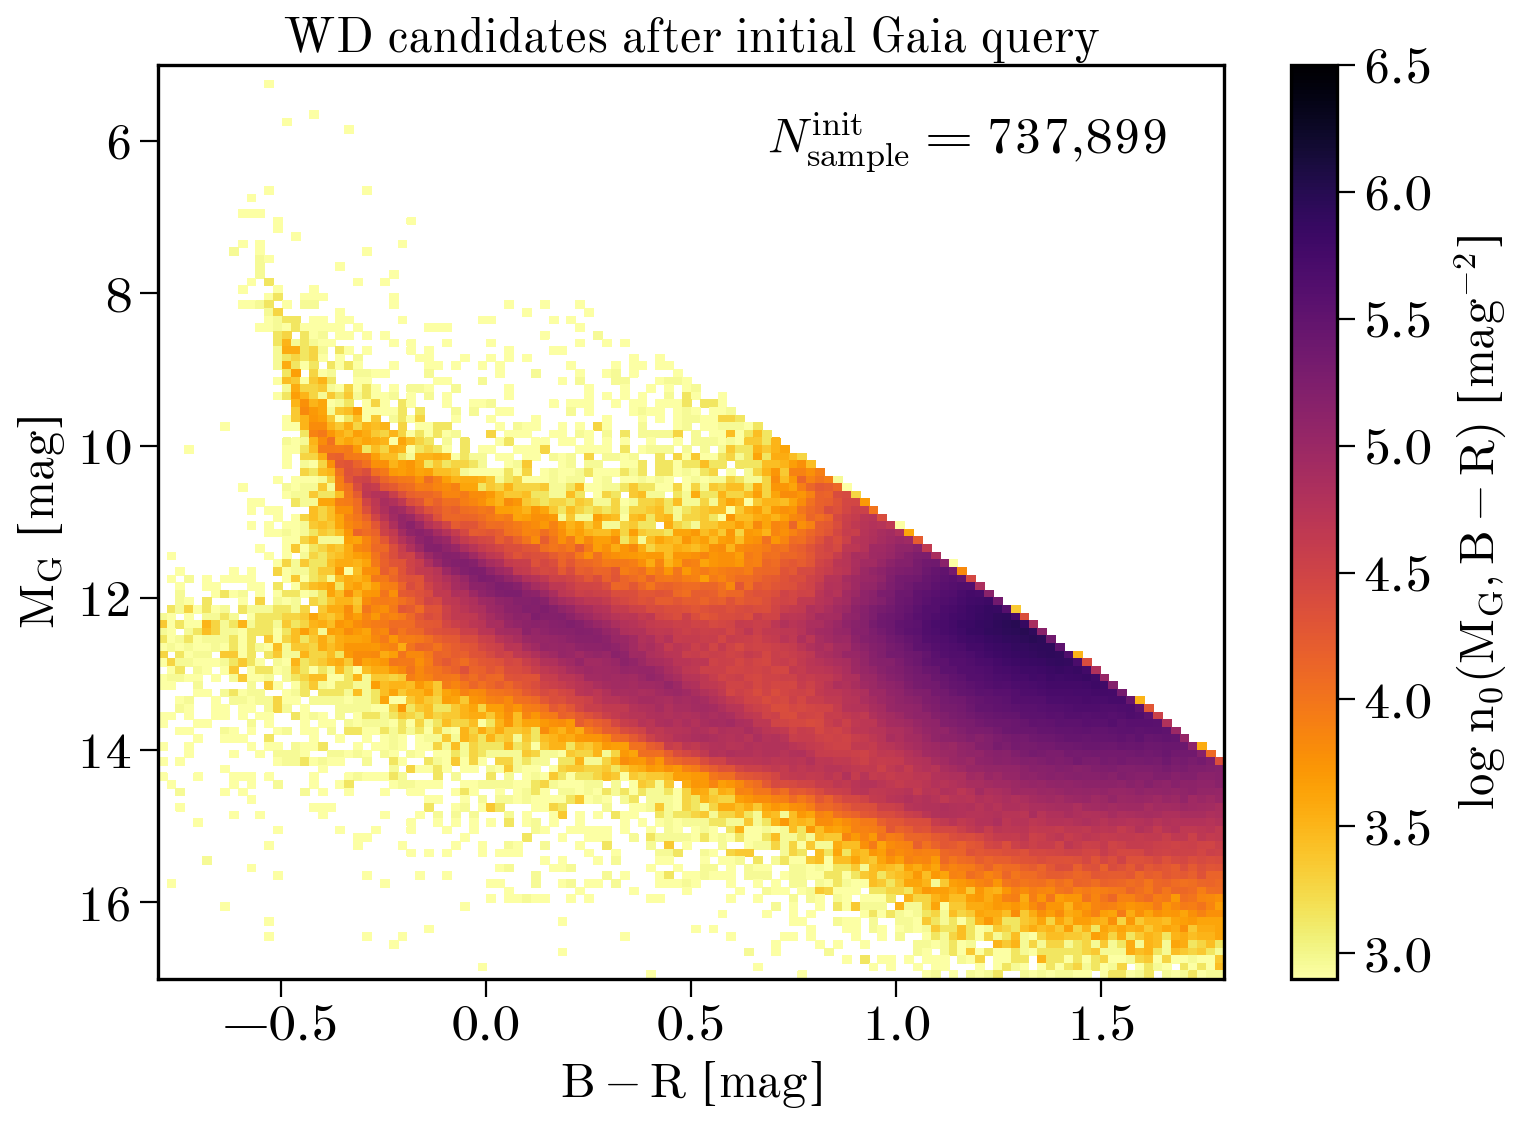

In [240]:
#@title make 2D density plot of sample at hand
# we start with the initial sample
fig, ax = make_cmd(MG, BmR, N_name='init')

ax.set_title(r'WD candidates after initial Gaia query')
fig.tight_layout()
filename = "initial_eDR3_query_CMD_distribution"
# fig.savefig(filename+".png", dpi=300);
# fig.savefig(filename+".pdf")

The plot above shows the enormous numbers of "spurious" sources that are in this largely empty part of the CAMD. Rybizki et al have devised an astrometric fidelity parameter (prob_v1), which is good at eliminating spurious sources. We have via the GAVO interface matched the above sample with fidelity_v1 and have picked fidelity_v1>0.9. This results in the following file which we plot analogously.

In [125]:
# read in the initial catalog
file_name = cache_path / 'WD-Jan31-2021-fidelity-ge-0.9.fits'
catalog_af = GaiaData(str(file_name))

# get the few columns we need; without subscript refers to the innitial sample
BmR_af = catalog_af.bp_rp.value
MG_af = (catalog_af.phot_g_mean_mag - catalog_af.distmod).value
l = catalog_af.l.value
b = catalog_af.b.value

print('read in {0:,d} catalog rows'.format(len(catalog_af)))

read in 126,638 catalog rows


APW note: changed "N^init" to "N^af"

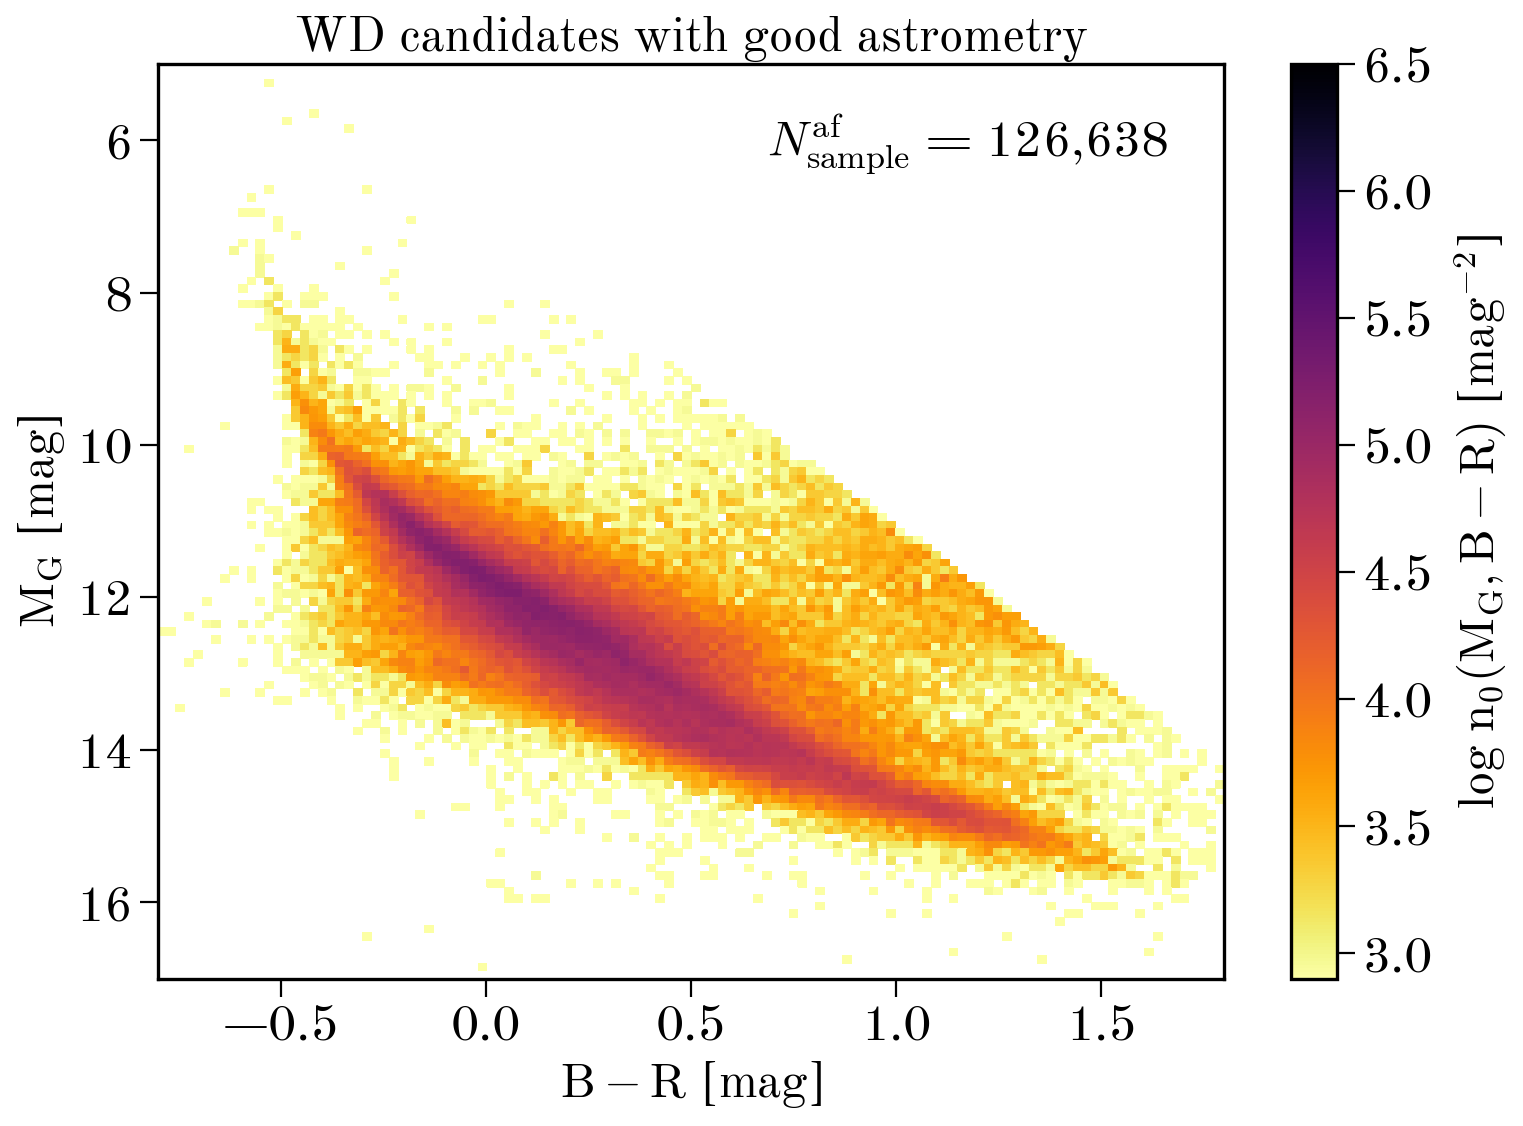

In [241]:
fig, ax = make_cmd(MG_af, BmR_af, N_name='af')

ax.set_title(r'WD candidates with good astrometry')

fig.tight_layout()
filename = "astrometric_fidelity_cleaned_CAMD_distribution"
# fig.savefig(filename+".png", dpi=300);
# fig.savefig(filename+".pdf")

Let's look at what this first cleaning did to the sky distrbution: it worked beautifully, as expected.

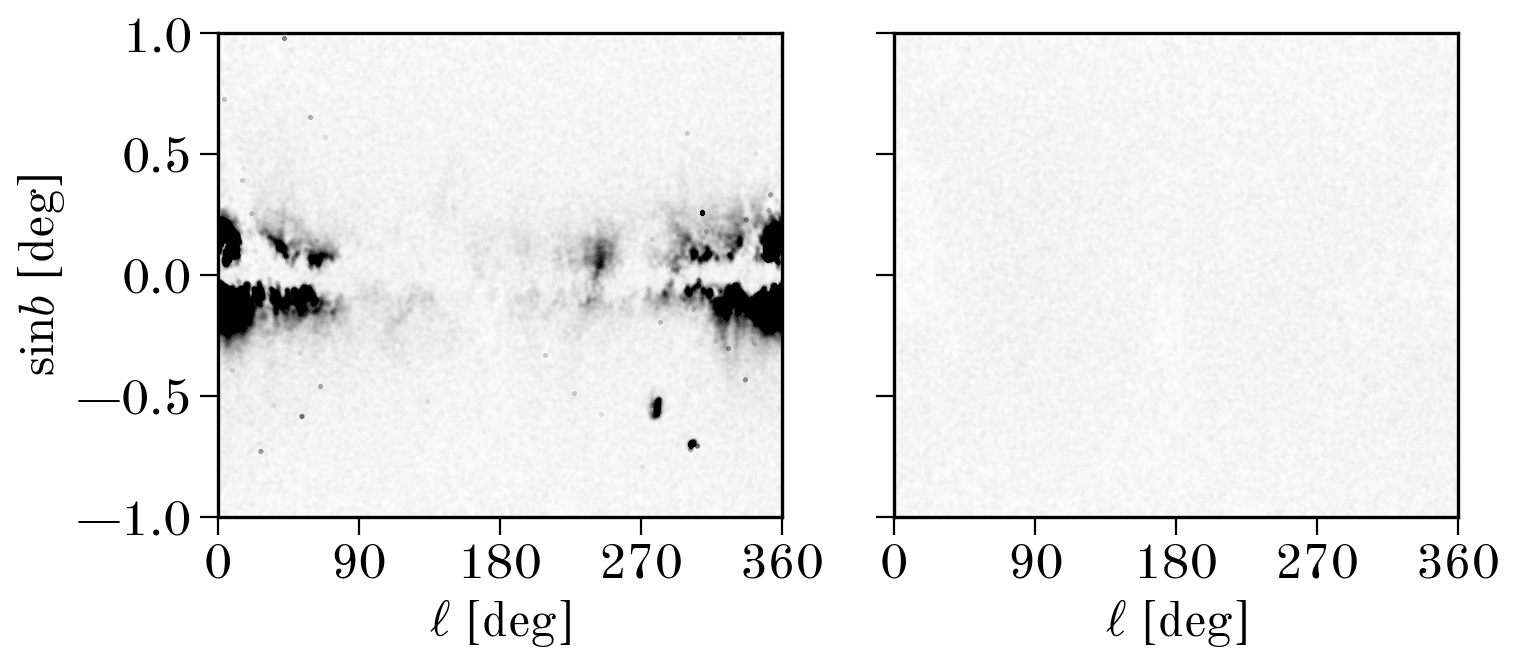

In [143]:
#@title Sky distribution: initial vs after current cleaning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.plot(catalog.l.value,
         np.sin(catalog.b),
         '.',
         color='black',
         alpha=0.002)
ax1.set_xlabel(r'$\ell$ [deg]')
ax1.set_ylabel(r'$\sin{b}$ [deg]')
ax2.plot(catalog_af.l.value,
         np.sin(catalog_af.b),
         '.',
         color='black',
         alpha=0.002)
plt.xlim(0, 360)
plt.ylim(-1, 1.)
plt.xticks(np.arange(0., 361., 90.))
#plt.yticks(np.arange(-1.7, 1.7, 0.5))
ax2.set_xlabel(r'$\ell$ [deg]');
#ax2.set_ylabel(r'$\sin{b}$');

And now, the next cleaning step, dubbed "astrophysical contaminants" in the draft. We will eliminate objects whose position in the color-color plane shows that their SEDs are more complex than a single black-body (stellar spectrum); we seek to model single WDs, which **all** should satisfy this criterion; again, a contamination reduction without significant completenes reduction (except that we will retain binary WDs where both components have similar T$_{eff}$).

We chosse BP-G *vs* G-RP as the coordinates of the color-color-plane. The two panels show the full extent of the color-color plane (left) and a zoom in to the single-stellar(WD) locus. The red dots show an eyeballed selection criterion, cast into a polynomial.


Make a 2D density histogram of sources in the B-G vs G-R plane; the first panel is a wide view, that shows all the WD-Mdwarf etc.. pairs.

In [145]:
BmG_af = (catalog_af.phot_bp_mean_mag - catalog_af.phot_g_mean_mag).value
GmR_af = (catalog_af.phot_g_mean_mag - catalog_af.phot_rp_mean_mag).value

# specify the grid on which to calculate the density
cc_gridsize = 200
xgrid = np.linspace(-4., 1.4, cc_gridsize+1)
ygrid = np.linspace(-1., 4.1, cc_gridsize+1)

# use the 2D density construction from (way) above
color_color_density, cc_xe, cc_ye = np.histogram2d(
    BmG_af, GmR_af, 
    bins=(xgrid, ygrid))

dc1 = xgrid[1] - xgrid[0]
dc2 = ygrid[1] - ygrid[0]
color_color_density /= dc1 * dc2
color_color_density = np.ma.masked_where(color_color_density <= 0, 
                                         color_color_density)

log_color_color_density = np.ma.log10(color_color_density)

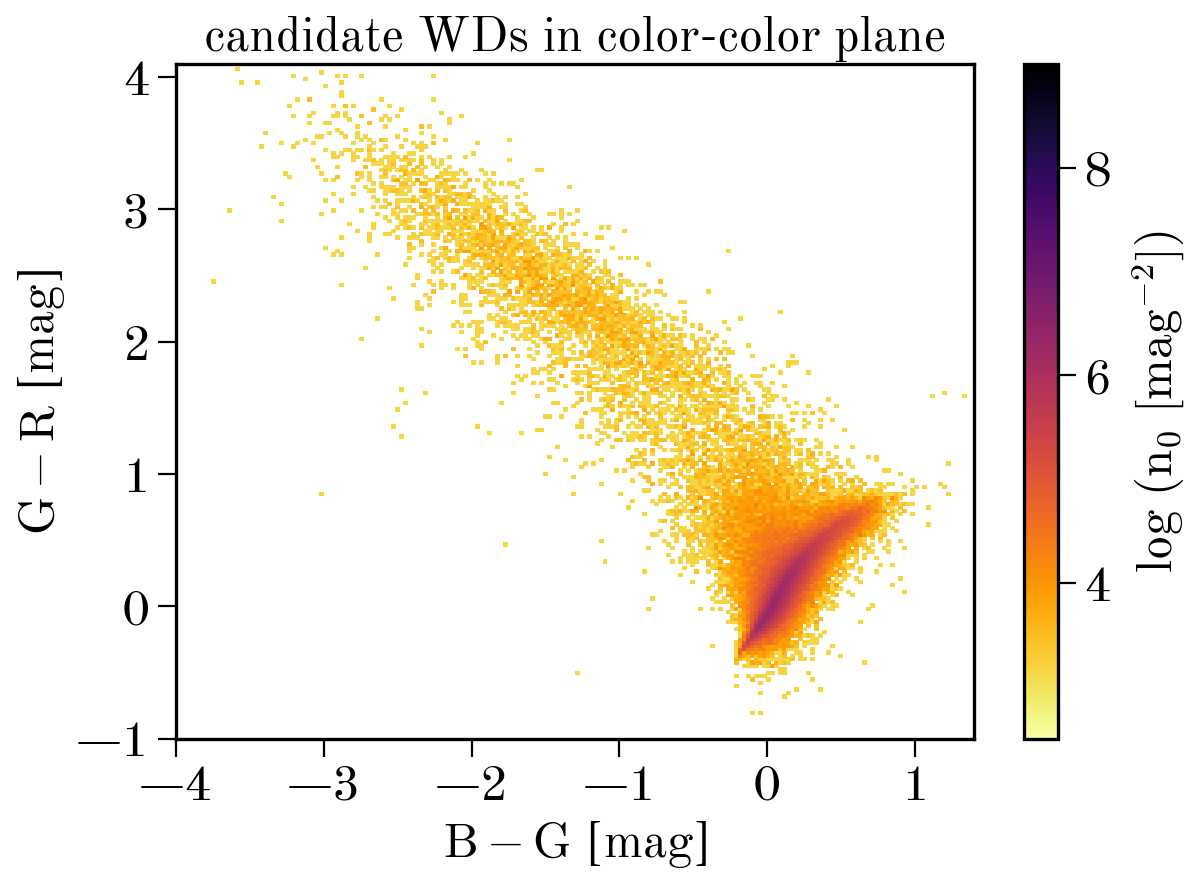

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), 
                       tight_layout=True)

im = ax.pcolormesh(
    cc_xe, cc_ye, log_color_color_density.T,
    cmap=cmap_r,
    vmin=2.5,
    vmax=9.)
ax.set_xlabel(r'$\mathrm{B}-\mathrm{G}$ [mag]')
ax.set_ylabel(r'$\mathrm{G}-\mathrm{R}$ [mag]')
ax.set_title(r'candidate WDs in color-color plane')
ax.set_xticks(np.arange(cc_xe.min(), cc_xe.max(), 1.))
ax.set_yticks(np.arange(cc_ye.min(), cc_ye.max(), 1.))
clb = fig.colorbar(im)
clb.set_label("log $( \mathrm{n}_0~[\mathrm{mag}^{-2}])$",
              labelpad=8,
              rotation=90)
file_name = 'color_color_distribution1'
# fig.savefig(file_name+'.png', dpi=300)
# fig.savefig(file_name+'.pdf')

Now we'll make a zoomed in version of the plot, and illustrate the color-color cut to isolate the simple SEDs.

In [148]:
# specify the grid on which to calculate the density
xgrid = np.linspace(-0.5, 1.05, cc_gridsize+1)
ygrid = np.linspace(-0.5, 1.2, cc_gridsize+1)

# use the 2D density construction from (way) above
color_color_density, cc_xe, cc_ye = np.histogram2d(
    BmG_af, GmR_af, 
    bins=(xgrid, ygrid))

dc1 = xgrid[1] - xgrid[0]
dc2 = ygrid[1] - ygrid[0]
color_color_density /= dc1 * dc2
color_color_density = np.ma.masked_where(color_color_density <= 0, 
                                         color_color_density)

log_color_color_density = np.ma.log10(color_color_density)

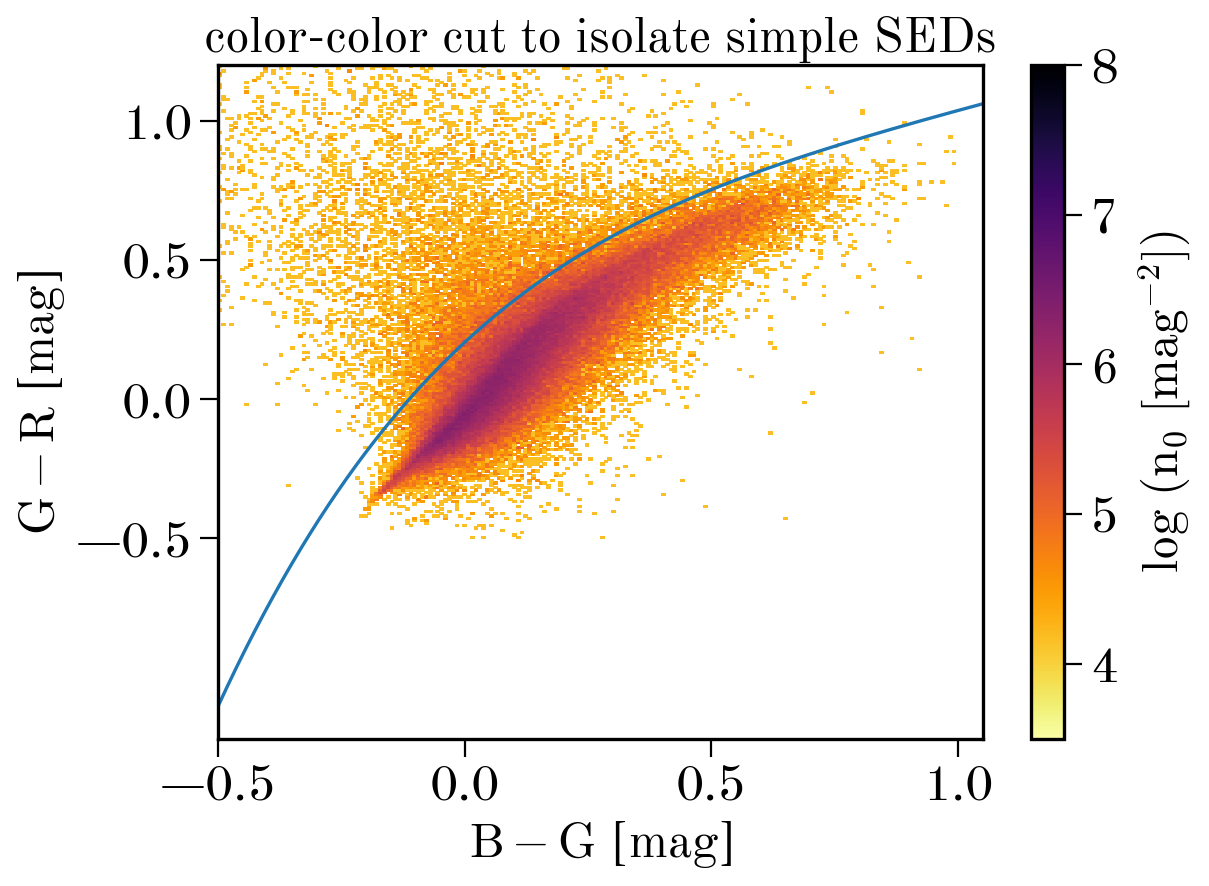

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), 
                       tight_layout=True)
                       
im = ax.pcolormesh(
    cc_xe, cc_ye, log_color_color_density.T,
    cmap=cmap_r,
    vmin=3.5,
    vmax=8.)

ax.set_xlabel(r'$\rm B-G$ [mag]')
ax.set_ylabel(r'$\rm G-R$ [mag]')
ax.set_title(r'color-color cut to isolate simple SEDs')
ax.set_xticks(np.arange(cc_xe.min(), cc_xe.max(), 0.5))
ax.set_yticks(np.arange(cc_ye.min(), cc_ye.max(), 0.5))
clb = fig.colorbar(im)
clb.set_label("log $( \mathrm{n}_0~[\mathrm{mag}^{-2}])$",
              labelpad=8,
              rotation=90
              )
file_name = 'color_color_distribution2'

x = np.linspace(cc_xe.min(), cc_xe.max(), num=500)
y = 0.48 + 1.15 * (x - 0.2) - 1.0 * (x - 0.2)**2 + 0.70 * (
    x - 0.2)**3. - 0.2 * (x - 0.2)**4
ax.plot(x, y, '-', color='tab:blue')#, alpha=0.9)

# fig.savefig(file_name+'.png', dpi=300)
# fig.savefig(file_name+'.pdf')

We now use this cut to pare down the sample, retaining only sample members "below" the line

In [155]:
#now demand that "good" objects lie below the red dots, i.e. satisfy the single-$T_{eff$}$ SED cut
x = BmG_af
GmRmax = (0.48 + 1.15 * (x - 0.2) - 1.0 * (x - 0.2)**2 + 
          0.70 * (x - 0.2)**3. - 0.2 * (x - 0.2)**4)

iselect = (GmR_af < GmRmax)
# subscript "_c" refers to quantities after the color-color cut
catalog_c = catalog_af[iselect]
BmR_c = BmR_af[iselect]
MG_c = MG_af[iselect]
print('We have now selected {0:,d} candidates'.format(len(MG_c)))

We have now selected 113,383 candidates


This cut seems like is was very effective to eliminate CVs, galaxies (? Ron says) etc..

Let's now look at what all that cleaning did to the sky distribution: it does look pleasing 

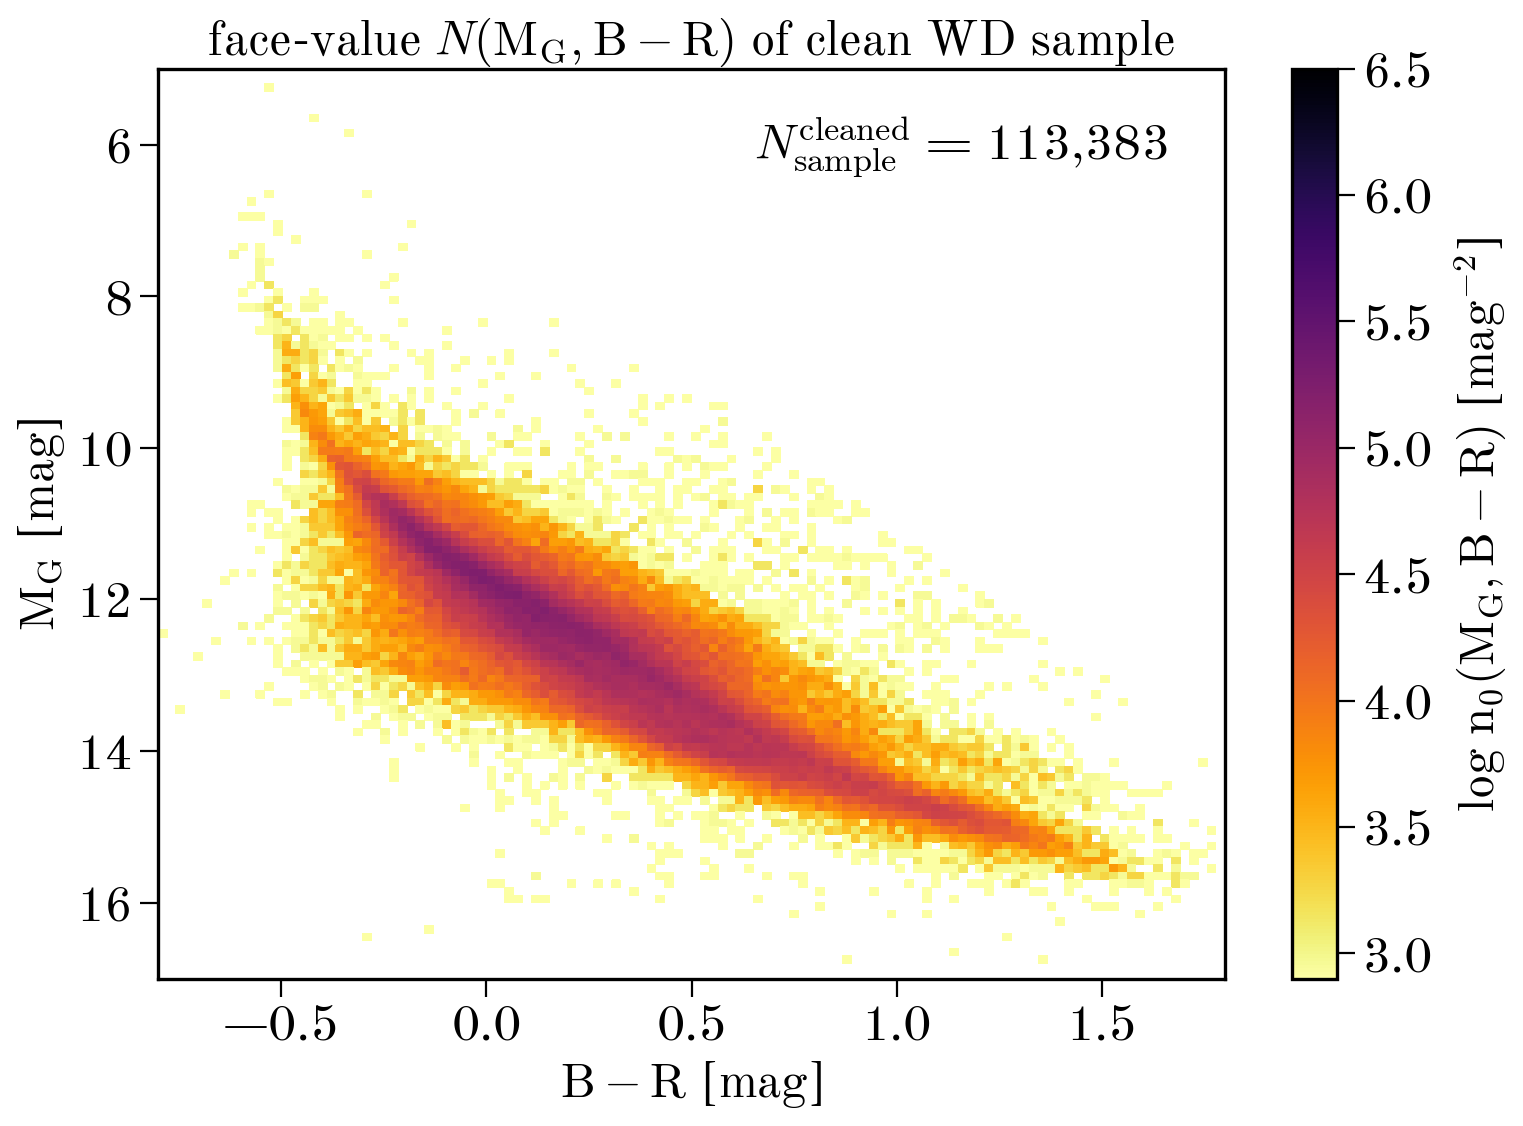

In [242]:
fig, ax = make_cmd(MG_c, BmR_c, N_name='cleaned')

ax.set_title(r'face-value $N(\mathrm{M}_\mathrm{G},\mathrm{B}-\mathrm{R})$ of clean WD sample')

fig.tight_layout()
filename = "WD300pc_af_cc_uncorr"
# fig.savefig(filename+".png", dpi=300);
# fig.savefig(filename+".pdf")

Let's check one more time what the sky distribution is that we ended up with ? Isotropic?

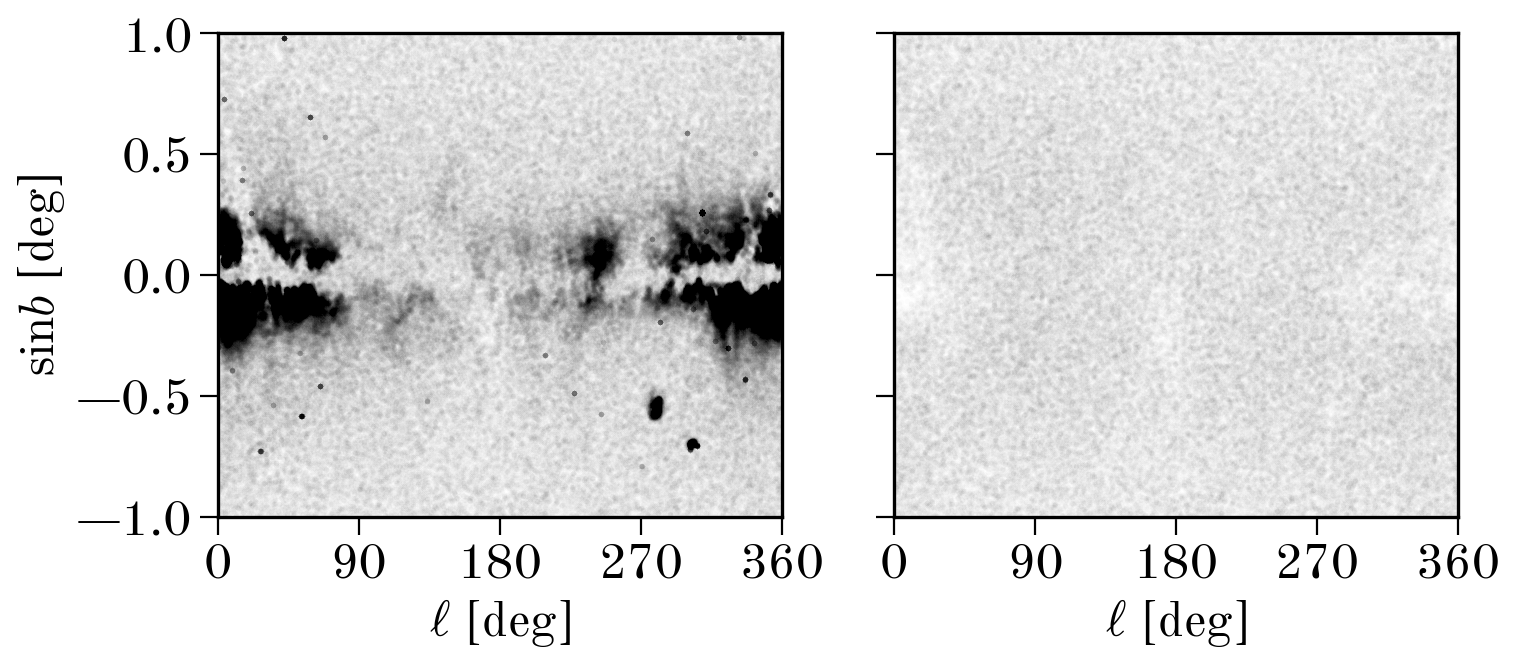

In [160]:
#@title Sky distribution: initial vs after current cleaning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.plot(catalog.l.value,
         np.sin(catalog.b),
         '.',
         color='black',
         alpha=0.01)
ax1.set_xlabel(r'$\ell$ [deg]')
ax1.set_ylabel(r'$\sin{b}$ [deg]')
ax2.plot(catalog_c.l.value,
         np.sin(catalog_c.b),
         '.',
         color='black',
         alpha=0.01)
plt.xlim(0, 360)
plt.ylim(-1, 1.)
plt.xticks(np.arange(0., 361., 90.))
#plt.yticks(np.arange(-1.7, 1.7, 0.5))
ax2.set_xlabel(r'$\ell$ [deg]');
#ax2.set_ylabel(r'$\sin{b}$');

## Now, on to the density calculation, via calculating the effective survey volume


Now calculate the maximal volume for each points, assuming a homogeneous distribution and no dust. There are three aspects that can limit the maximal volume (Eq. 12 in the draft):
1. the formal parallax cut
2. the magnitude limit
3. the plxSNlim

In [175]:
# to start calculateing the LCF of white dwarfs Phi_0(M,c) we adopt some fiducial sub-sample cuts
mG_ref = 22.  # this is the empirical calibration of (mG,varpi) --> plxS/N (see Eq. 3 in paper)
Glimit = 19.5 # we don't push to the faintest limits
plxSNmin = 20.  # it is this parameter that we will modify later, we will take "20" as our fiducial SN_varpi
plxcut = 3.  # <333 pc
hz = 300 * u.pc # a density scale height of 300pc

# subscript "_cut" refers to the sample aftetr (various) plxS/N cuts
# the following has been modified/corrected March 6, 2021; see Eq 3 & 4 in the paper
# note that the cuts here are on the expected<S/N_plx> = f(m_G , varpi)
iselect = (
    (catalog_c.phot_g_mean_mag.value <= Glimit) &
    (catalog_c.parallax.to_value(u.mas) >= plxcut) &
    (catalog_c.parallax.value * 10.**(-(catalog_c.phot_g_mean_mag.value - mG_ref) / 5.) >= plxSNmin)
)

catalog_cut = catalog_c[iselect]
BmR_cut = catalog_cut.bp_rp.value
MG_cut = (catalog_cut.phot_g_mean_mag - catalog_cut.distmod).value
print('The initial catalog of ', len(catalog_c),
      ' sample members gets pared down to', len(catalog_cut))

The initial catalog of  113383  sample members gets pared down to 52373


For the subsequent steps we need two auxilliary functions: the one, get_Veff calculate the actual maximal volume within which the object would has S_C~1; the second one, is a dummy, it just counts each sample members volume as "1", so that we can make analogous maks that are N(M,c), not Phi_0(M,c).

In [204]:
#@title functions to calculate V_eff; and a "dummy version" thereof
# assign to each object in 'catalog' a Veff; not catalog must have columns 'parallax' and 'phot_g_mean_mag'
# the assumption is that we have cuts in parallax (plxmin), magnitude (Glimit), and PlsS/N
# there are three possible issues that limit Veff: plxcit, Gmin o plxSN; hence thee cases
def get_Veff1(M, Glimit, plxSNmin, plxcut):  # obsolete, parked here
    mG_ref = 22. # reference magnitude so that m and varpi yield a cetain plxSN; empiically calibrated fom eDR3
    four_pi_thirds = 4 * np.pi / 3.
    Veff_1 = four_pi_thirds / plxcut**3
    Veff_2 = four_pi_thirds / (10**( (M + 10 - Glimit) / 5) )**3
    Veff_3 = four_pi_thirds / (np.sqrt(plxSNmin)*10**((M + 10 - mG_ref) / 10.))**3
    return np.minimum(np.minimum(Veff_1, Veff_2), Veff_3)


def get_Veff(M, Glimit, plxSNmin, plxcut):
    mG_ref = 22. # reference magnitude so that m and varpi yield a cetain plxSN; empiically calibrated fom eDR3
#     plx_1,plx_2,plx_3 = plxcut,  10**( (M + 10 - Glimit) / 5),\
#                         np.sqrt(plxSNmin)*10**((M + 10 - mG_ref) / 10.)
#     plxmin = np.maximum(np.maximum(plx_1, plx_2), plx_3)
    plxmin = np.max([
        np.full_like(M, plxcut), 
        10**( (M + 10 - Glimit) / 5),
        np.sqrt(plxSNmin)*10**((M + 10 - mG_ref) / 10)
    ], axis=0)
    return (4 * np.pi / 3.) / plxmin**3 

In the Cell below, we provide the code that does the Veff calculation for the case of a density slab, with a vertically Gaussian profile or scale-height h_z

In [205]:
###################
# these are the pieces needed for calculating the effective volume for the vertically-Gaussian slab of scale-height h_z

def integrand(plx, b, hz):
    return np.cos(b) / plx**4 * np.exp(-0.5 * (np.sin(b)/plx / hz)**2)

def generalized_Veff(plxmin, hz):  # this is the analytic result, for latitude b and minimal parallax plxmin
    return 2. * np.pi * dblquad(
        integrand,
        -np.pi/2., np.pi/2., 
        lambda plx: plxmin, lambda plx: np.inf, 
        args=(hz, ))[0]

#  this function takes an input vector of absolute magnitudes M to calculate plxmin = f(M,Glimit,plxSNmin & plxcut)
#  and then feeds it into the generalized_Veff above to calculate the effective volume.
# to speed things up, we construct an array of abs.mag M first, precalculate Veff, and then in the modelling interpolate.
def get_Veff2(M,Glimit,plxSNmin,plxcut,hz):
    mG_ref = 22. # reference magnitude so that m and varpi yield a cetain plxSN; empiically calibrated fom eDR3
    
    plxmin = np.max([
        np.full_like(M, plxcut), 
        10**( (M + 10 - Glimit) / 5),
        np.sqrt(plxSNmin)*10**((M + 10 - mG_ref) / 10)
    ], axis=0)
    
    return np.array([generalized_Veff(x, hz) for x in plxmin])

#hz=0.30   # scale height of 300pc; fixed here defined above
# do pre-calculation
Mtest = np.arange(3., 30., 0.04)  # enormous range of possible abs. mag.
Veff_test = get_Veff2(Mtest, Glimit, plxSNmin, plxcut, hz.to_value(u.kpc))
# now define the interpolation of Veff(M), as speed-up
temp = interp1d(Mtest, Veff_test)
# this now is the decisive call; NOTE that Glimit,plxSNmin,plxcut,hz need to be appropriately defined; 
# they do not appear here
Veff_interp = np.vectorize(temp)
###################

Now get the Veff for all objects in catalog_cut, taken with the first fiducial set of G,varpi,SNvarpi parameters.
The point here is to illustrate that for same sources the magnitude, for some the parallax, and for some the SNplx lmits the survey volume.

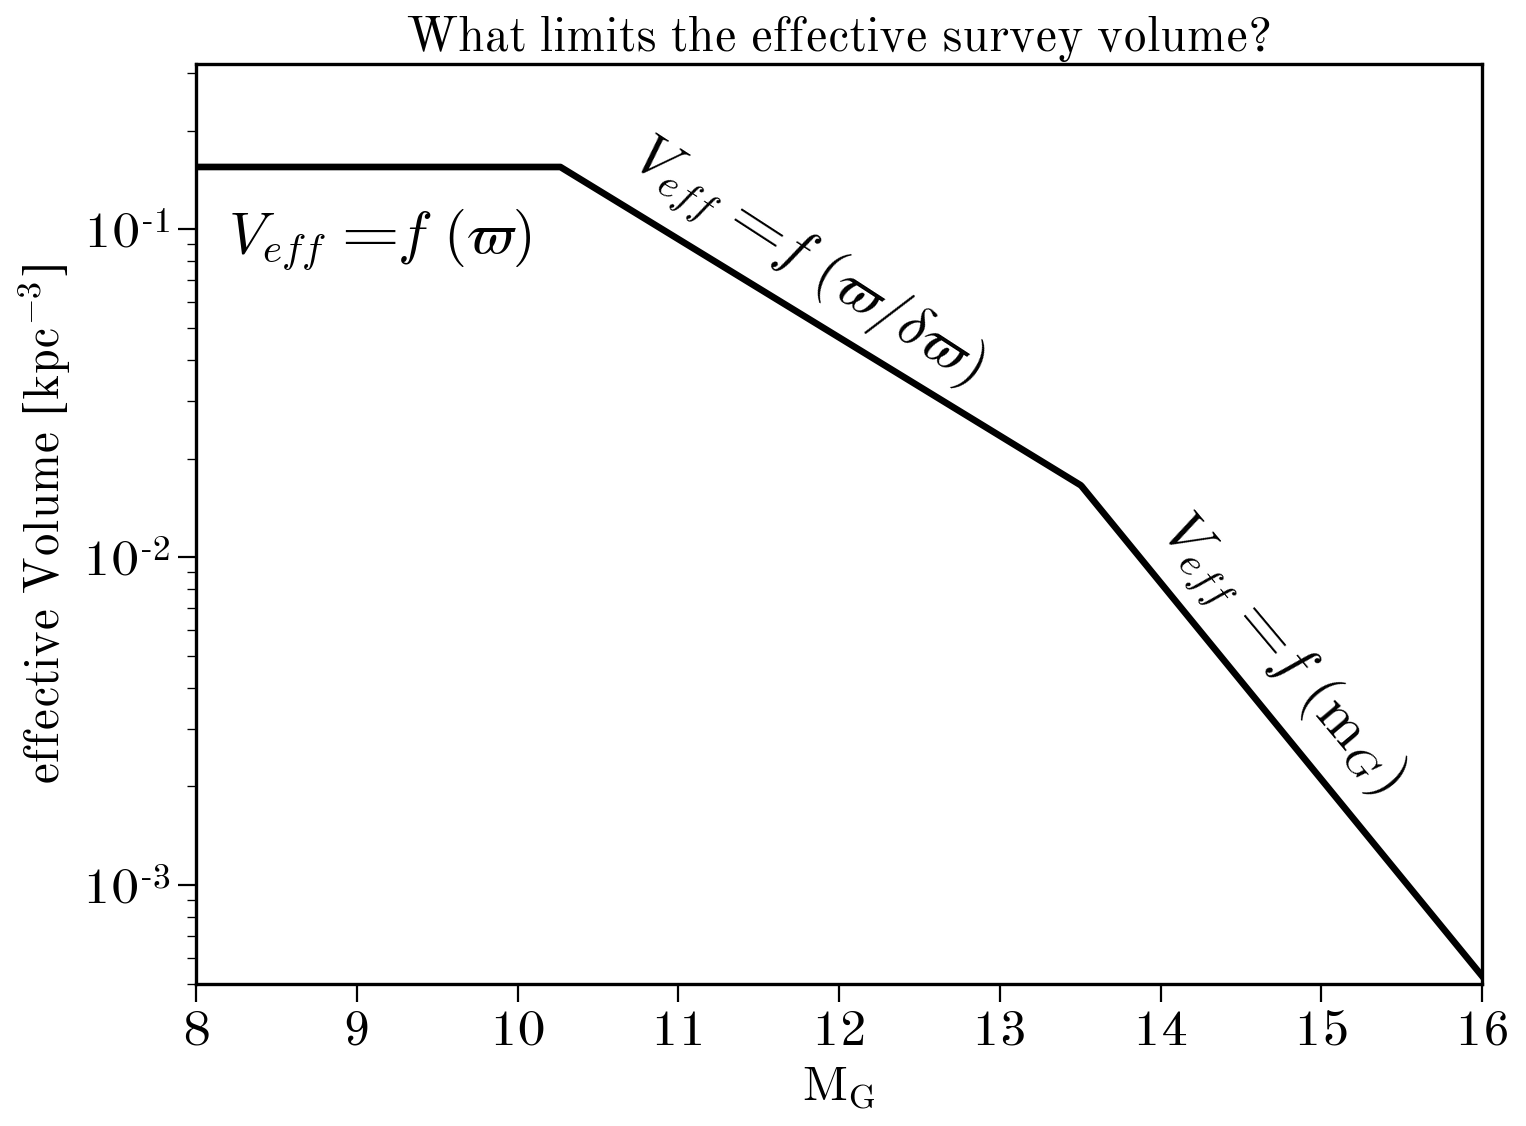

In [206]:
#@title illustrate how the effective volume depends on M_G
MG_cut_list = np.linspace(8,16,1000)
Veff_cut = get_Veff( MG_cut_list, Glimit, plxSNmin, plxcut)
##Veff_cut =eff_interp( MG_cut )

fig, ax = plt.subplots(1, 1, figsize=(10,7.5), tight_layout=True)
                       
ax.plot(MG_cut_list, Veff_cut, '-', color='C0', alpha=1., lw=3)
ax.set_xlabel(r'$\mathrm{M}_\mathrm{G}$')
ax.set_ylabel('effective Volume [kpc$^{-3}$]')
ax.set_title(r'What limits the effective survey volume?')
ax.set_ylim(0.0005, 0.32)
ax.set_xlim(8., 16.)
ax.text(8.2,
         0.085,
         r'$V_{eff}~$=$f~(\varpi)$',
         fontsize="large",
         rotation=0,
         rotation_mode='anchor')
ax.text(10.7,
         0.16,
         r'$V_{eff}~$=$f~(\varpi / \delta\varpi)$',
         fontsize="large",
         rotation=-33,
         rotation_mode='anchor')
ax.text(14.0,
         0.012,
         r'$V_{eff}~$=$f~(\mathrm{m}_G)$',
         fontsize="large",
         rotation=-50,
         rotation_mode='anchor')
ax.semilogy()
filename = f"Veff-{np.int(plxSNmin)}"
# plt.savefig(filename+".png", dpi=300)
# plt.savefig(filename+".pdf")

Now, let's set up a 100x100 grid in MG-(B-R) space, weigh each point by 1./Veff(M_G)
and make a plot; this is effectively the luminosity-color function of single WDs, Phi_0(M,c).

Again, this starts with defning two function calls for getting the (dummy/real) density; we'll make several plots along these lines.

Now we will make the first WD CLF on the grid just specified, taking default parameters

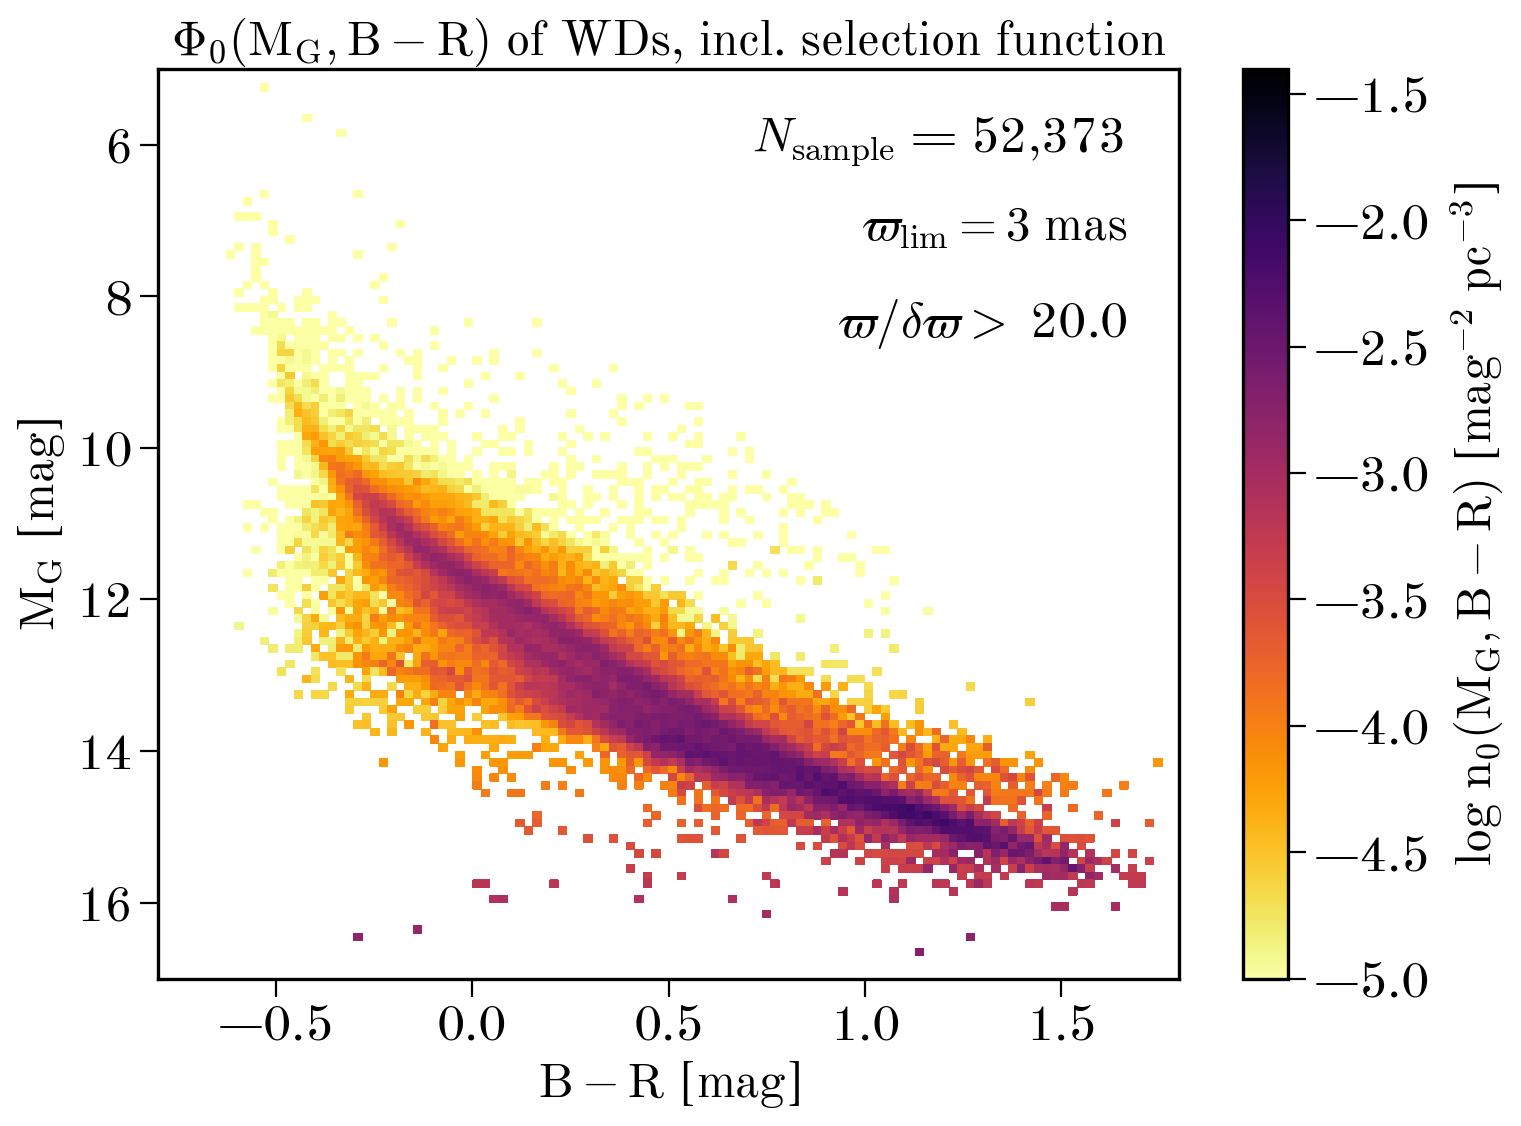

In [243]:
#@title Estimate Phi_0(M,c), using the effective volume from the selection function
Veff_cut = get_Veff( MG_cut, Glimit, plxSNmin, plxcut)
distribution, xe, ye = get_density(MG_cut, BmR_cut, Veff=Veff_cut)

fig, ax = plt.subplots(1, 1, figsize=(10,7.5), tight_layout=True)

im = ax.pcolormesh(
        xe, ye, distribution.T - 9,  # kpc^-3 to pc^-3
        cmap=cmap_r,
        vmin=-5.0, vmax=-1.4)

ax.set_xlabel(r'$\mathrm{B}-\mathrm{R}$ [mag]')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{G}$ [mag]')
ax.set_title(r'$\Phi_0(\mathrm{M}_\mathrm{G},\mathrm{B}-\mathrm{R})$ of WDs, incl. selection function')
clb = fig.colorbar(im)
clb.set_label(
    "log $\mathrm{n}_0(\mathrm{M}_\mathrm{G},\mathrm{B}-\mathrm{R})$ [mag$^{-2}$ pc$^{-3}$]",
    labelpad=8,
    rotation=90)
#plt.text(0.4, 6.5, "N$_{sample}$ = " + str(len(Veff_cut)), fontsize='small')
#plt.text(0.5, 8., r"$\varpi_{lim}=3$ mas", fontsize='small')
#plt.text(0.5, 9.5, r"$\varpi/\delta\varpi>$ " + str(plxSNmin), fontsize='small')
ax.text(0.95,
         0.95,
         "$N_\mathrm{{sample}}$ = {0:,d} ".format(len(Veff_cut)),
         fontsize='medium',
         transform=plt.gca().transAxes,
         va='top',
         ha='right')
ax.text(0.95,
         0.85,
         r"$\varpi_\mathrm{lim}=3$ mas",
         fontsize='medium',
         transform=plt.gca().transAxes,
         va='top',
         ha='right')
ax.text(0.95,
         0.75,
         r"$\varpi/\delta\varpi >$ " + str(plxSNmin),
         fontsize='medium',
         transform=plt.gca().transAxes,
         va='top',
         ha='right')

ax.set_xlim(xe.min(), xe.max())
ax.set_ylim(ye.max(), ye.min())

filename = f"WD300pc_plxSN_{np.int(plxSNmin):d}"
# plt.savefig(filename+".png", dpi=300)
# plt.savefig(filename+".pdf")

Now we will make a map that looks like the above, but just has V_eff, i.e. presumes that each pixel has 1 point in it

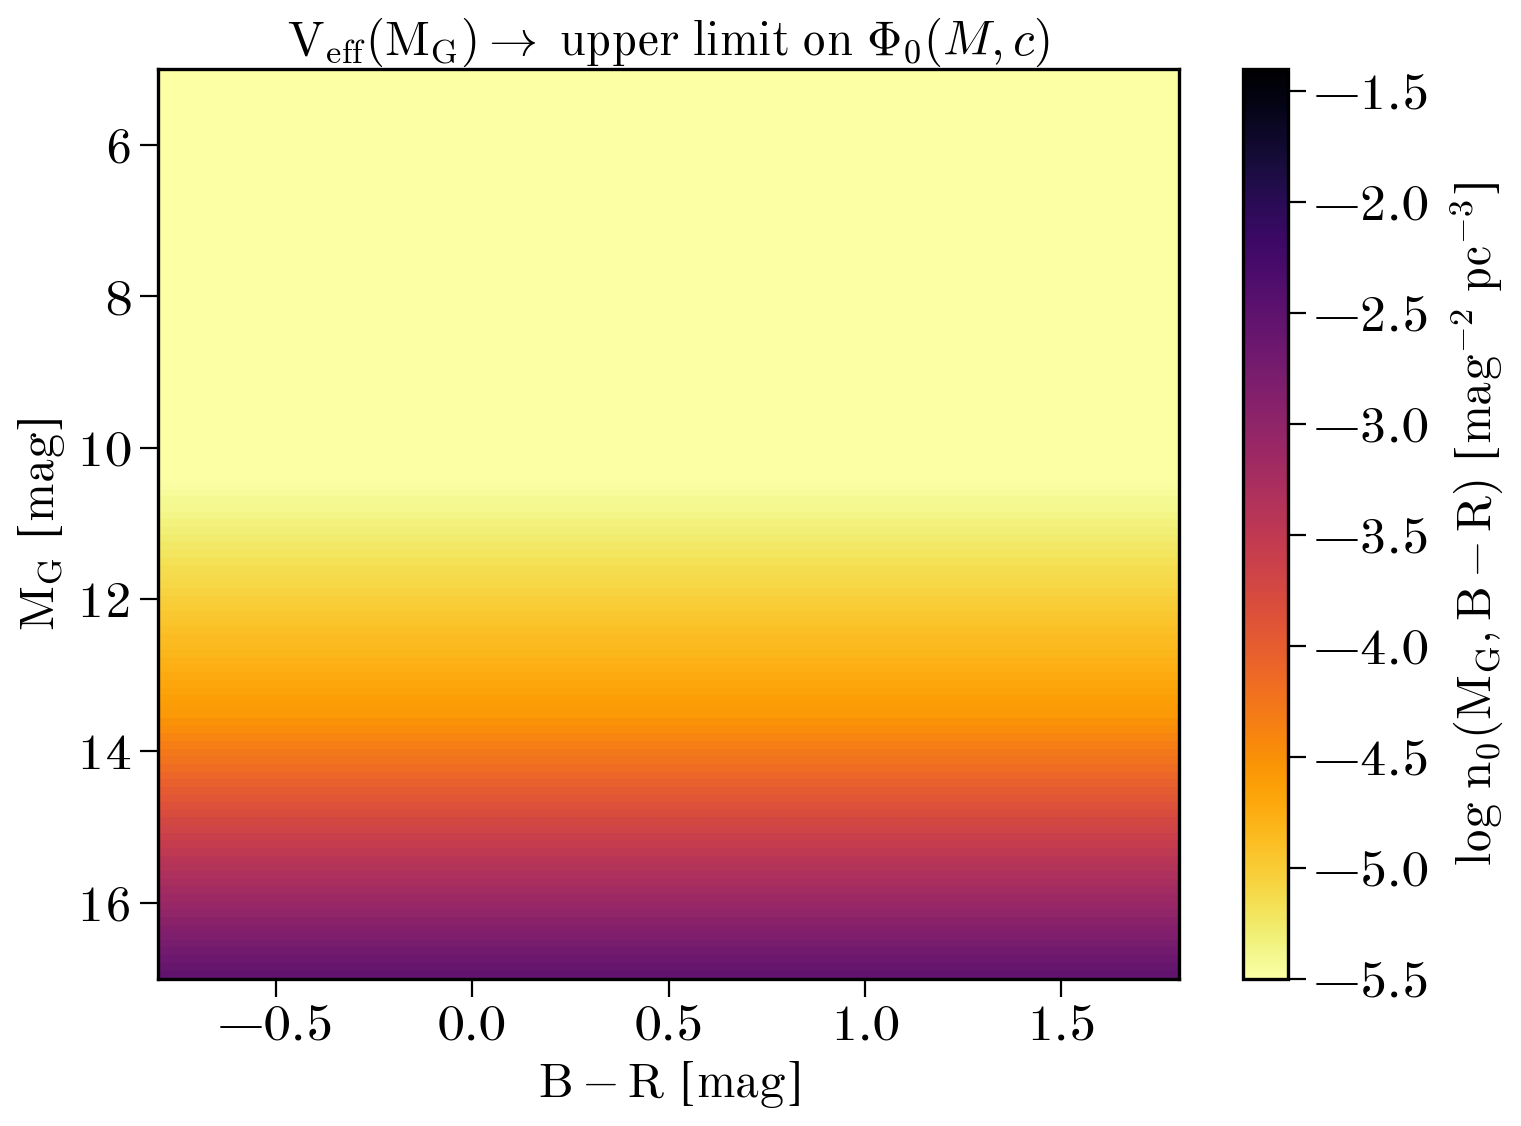

In [339]:
#@title Create a plot that shows V_eff

# Evaluate Veff on a grid:
M_vals = np.linspace(MGmin, MGmax, cmd_gridsize)
c_vals = np.linspace(BmRmin, BmRmax, cmd_gridsize)  
M_grid, c_grid = np.meshgrid(M_vals, c_vals)

dM = (M_vals[1] - M_vals[0])
dc = (c_vals[1] - c_vals[0])

Veff = get_Veff(M_grid, Glimit, plxSNmin, plxcut)
distribution_dummy = np.log10(1 / Veff / (dM * dc)) - 9  # kpc^-3 to pc^-3

fig, ax = plt.subplots(1, 1, figsize=(10,7.5), tight_layout=True)

im = ax.pcolormesh(
    c_vals, M_vals, 
    distribution_dummy.T, 
    cmap=cmap_r,
    vmin=-5.5,
    vmax=-1.4)
ax.set_xlabel(r'$\mathrm{B}-\mathrm{R}$ [mag]')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{G}$ [mag]')
ax.set_title(r'$\mathrm{V}_\mathrm{eff}(\mathrm{M}_\mathrm{G})\rightarrow $ upper limit on $\Phi_0(M,c)$')
clb = fig.colorbar(im)
clb.set_label(
    r"log $\mathrm{n}_0(\mathrm{M}_\mathrm{G},\mathrm{B}-\mathrm{R})$ [mag$^{-2}$ pc$^{-3}$]",
    labelpad=8,
    rotation=90)

filename = "WD300pc_survey_volume"
# plt.savefig(filename+".png", dpi=300)
# plt.savefig(filename+".pdf")

Let's now compare this to the un-corrected distribution: we do this by setting Veff=1 for all points

In [334]:
distribution[~distribution.mask].max()

5.029695882967707

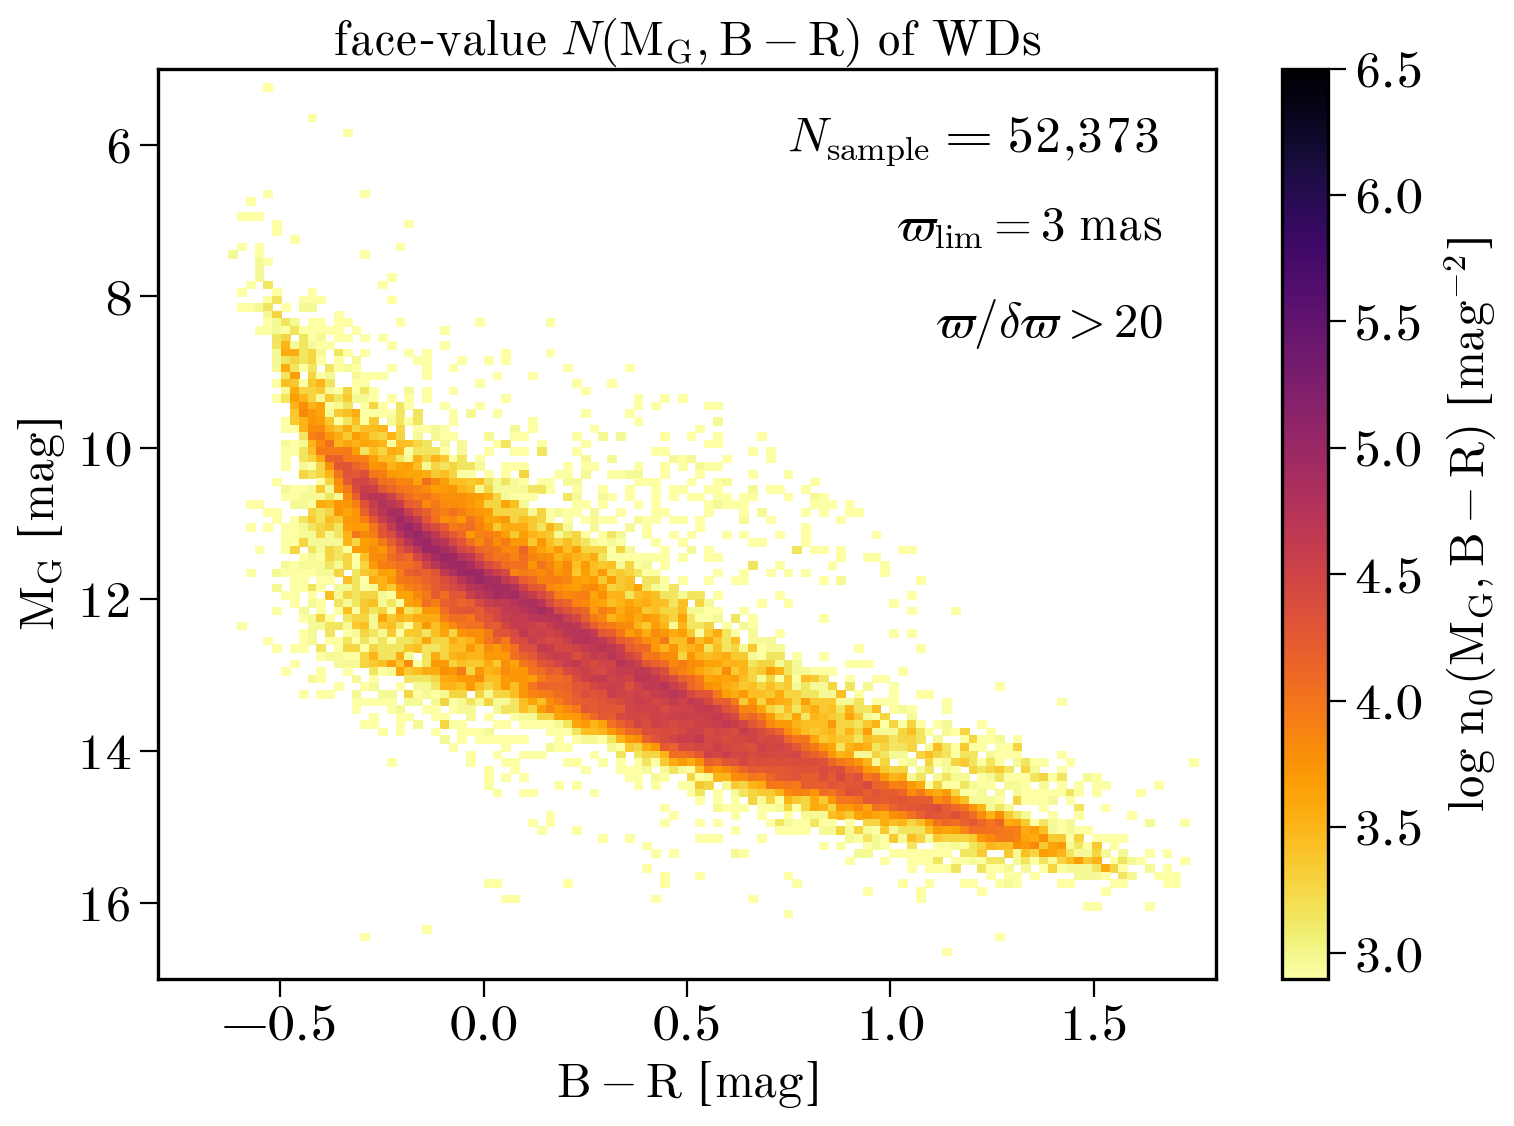

In [340]:
Veff_dummy = np.ones(len(MG_cut))
distribution, xe, ye = get_density(MG_cut, BmR_cut, Veff=Veff_dummy)

fig, ax = plt.subplots(1, 1, figsize=(10,7.5), tight_layout=True)

im = ax.pcolormesh(
        xe, ye, distribution.T,
        cmap=cmap_r,
        vmin=2.9, vmax=6.5)

ax.set_xlabel(r'$\mathrm{B}-\mathrm{R}$ [mag]')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{G}$ [mag]')
ax.set_title(r'face-value $N(\mathrm{M}_\mathrm{G}, \mathrm{B}-\mathrm{R})$ of WDs')
clb = fig.colorbar(im)
clb.set_label(
    r"log $\mathrm{n}_0(\mathrm{M}_\mathrm{G}, \mathrm{B}-\mathrm{R})$ [mag$^{-2}$]",
    labelpad=8,
    rotation=90)
plt.text(0.95,
         0.95,
         "$N_\mathrm{{sample}}$ = {0:,d} ".format(len(Veff_dummy)),
         fontsize='medium',
         transform=ax.transAxes,
         va='top',
         ha='right')
plt.text(0.95,
         0.85,
         r"$\varpi_\mathrm{lim}=3$ mas",
         fontsize='medium',
         transform=ax.transAxes,
         va='top',
         ha='right')
plt.text(0.95,
         0.75,
         r"$\varpi/\delta\varpi > {0:d}$".format(np.int(plxSNmin)),
         fontsize='medium',
         transform=ax.transAxes,
         va='top',
         ha='right')
# plt.text(0.4, 6.5, r"N$_{sample}$ = " + str(len(Veff_dummy)), fontsize='small')
# plt.text(0.5, 8., r"$\varpi_{lim}=3$ mas", fontsize='small')
# plt.text(0.5, 9.5, r"$\varpi/\delta\varpi >$ " + str(plxSNmin), fontsize='small')

ax.set_xlim(xe.min(), xe.max())
ax.set_ylim(ye.max(), ye.min())

filename = "WD300pc_plxSN_{0:d}_uncorr".format(np.int(plxSNmin))
# plt.savefig(filename+".png", dpi=300)
# plt.savefig(filename+".pdf")

We will now explore the impact of changing some of the selection cuts for the sample; the estimate of the CLF should remain unbiased. More lenient $\delta\varpi/\varpi$ cuts will give larger samples, but also larger error bars in $M_G$, hence less "resolution".

In [357]:
sub_distributions = {}
sub_Ns = {}
for plxSNmin in [5., 10, 40, 80]:
    iselect = (
        (catalog_c.phot_g_mean_mag.value <= Glimit) &
        (catalog_c.parallax.to_value(u.mas) >= plxcut) &
        (catalog_c.parallax.value * 10.**(-(catalog_c.phot_g_mean_mag.value - mG_ref) / 5.) >= plxSNmin)
    )

    catalog_cut = catalog_c[iselect]
    BmR_cut = catalog_cut.bp_rp.value
    MG_cut = (catalog_cut.phot_g_mean_mag - catalog_cut.distmod).value
    print('The initial catalog of ', len(catalog_c),
          ' sample members gets pared down to', len(catalog_cut))
    
    # and get Veff for this subsample
    Veff_cut = get_Veff( MG_cut, Glimit, plxSNmin, plxcut)
    distribution, xe, ye = get_density(MG_cut, BmR_cut, Veff=Veff_cut)
    
    sub_distributions[plxSNmin] = distribution
    sub_Ns[plxSNmin] = len(Veff_cut)
    sub_xe = xe
    sub_ye = ye

The initial catalog of  113383  sample members gets pared down to 80439
The initial catalog of  113383  sample members gets pared down to 80177
The initial catalog of  113383  sample members gets pared down to 23694
The initial catalog of  113383  sample members gets pared down to 9080


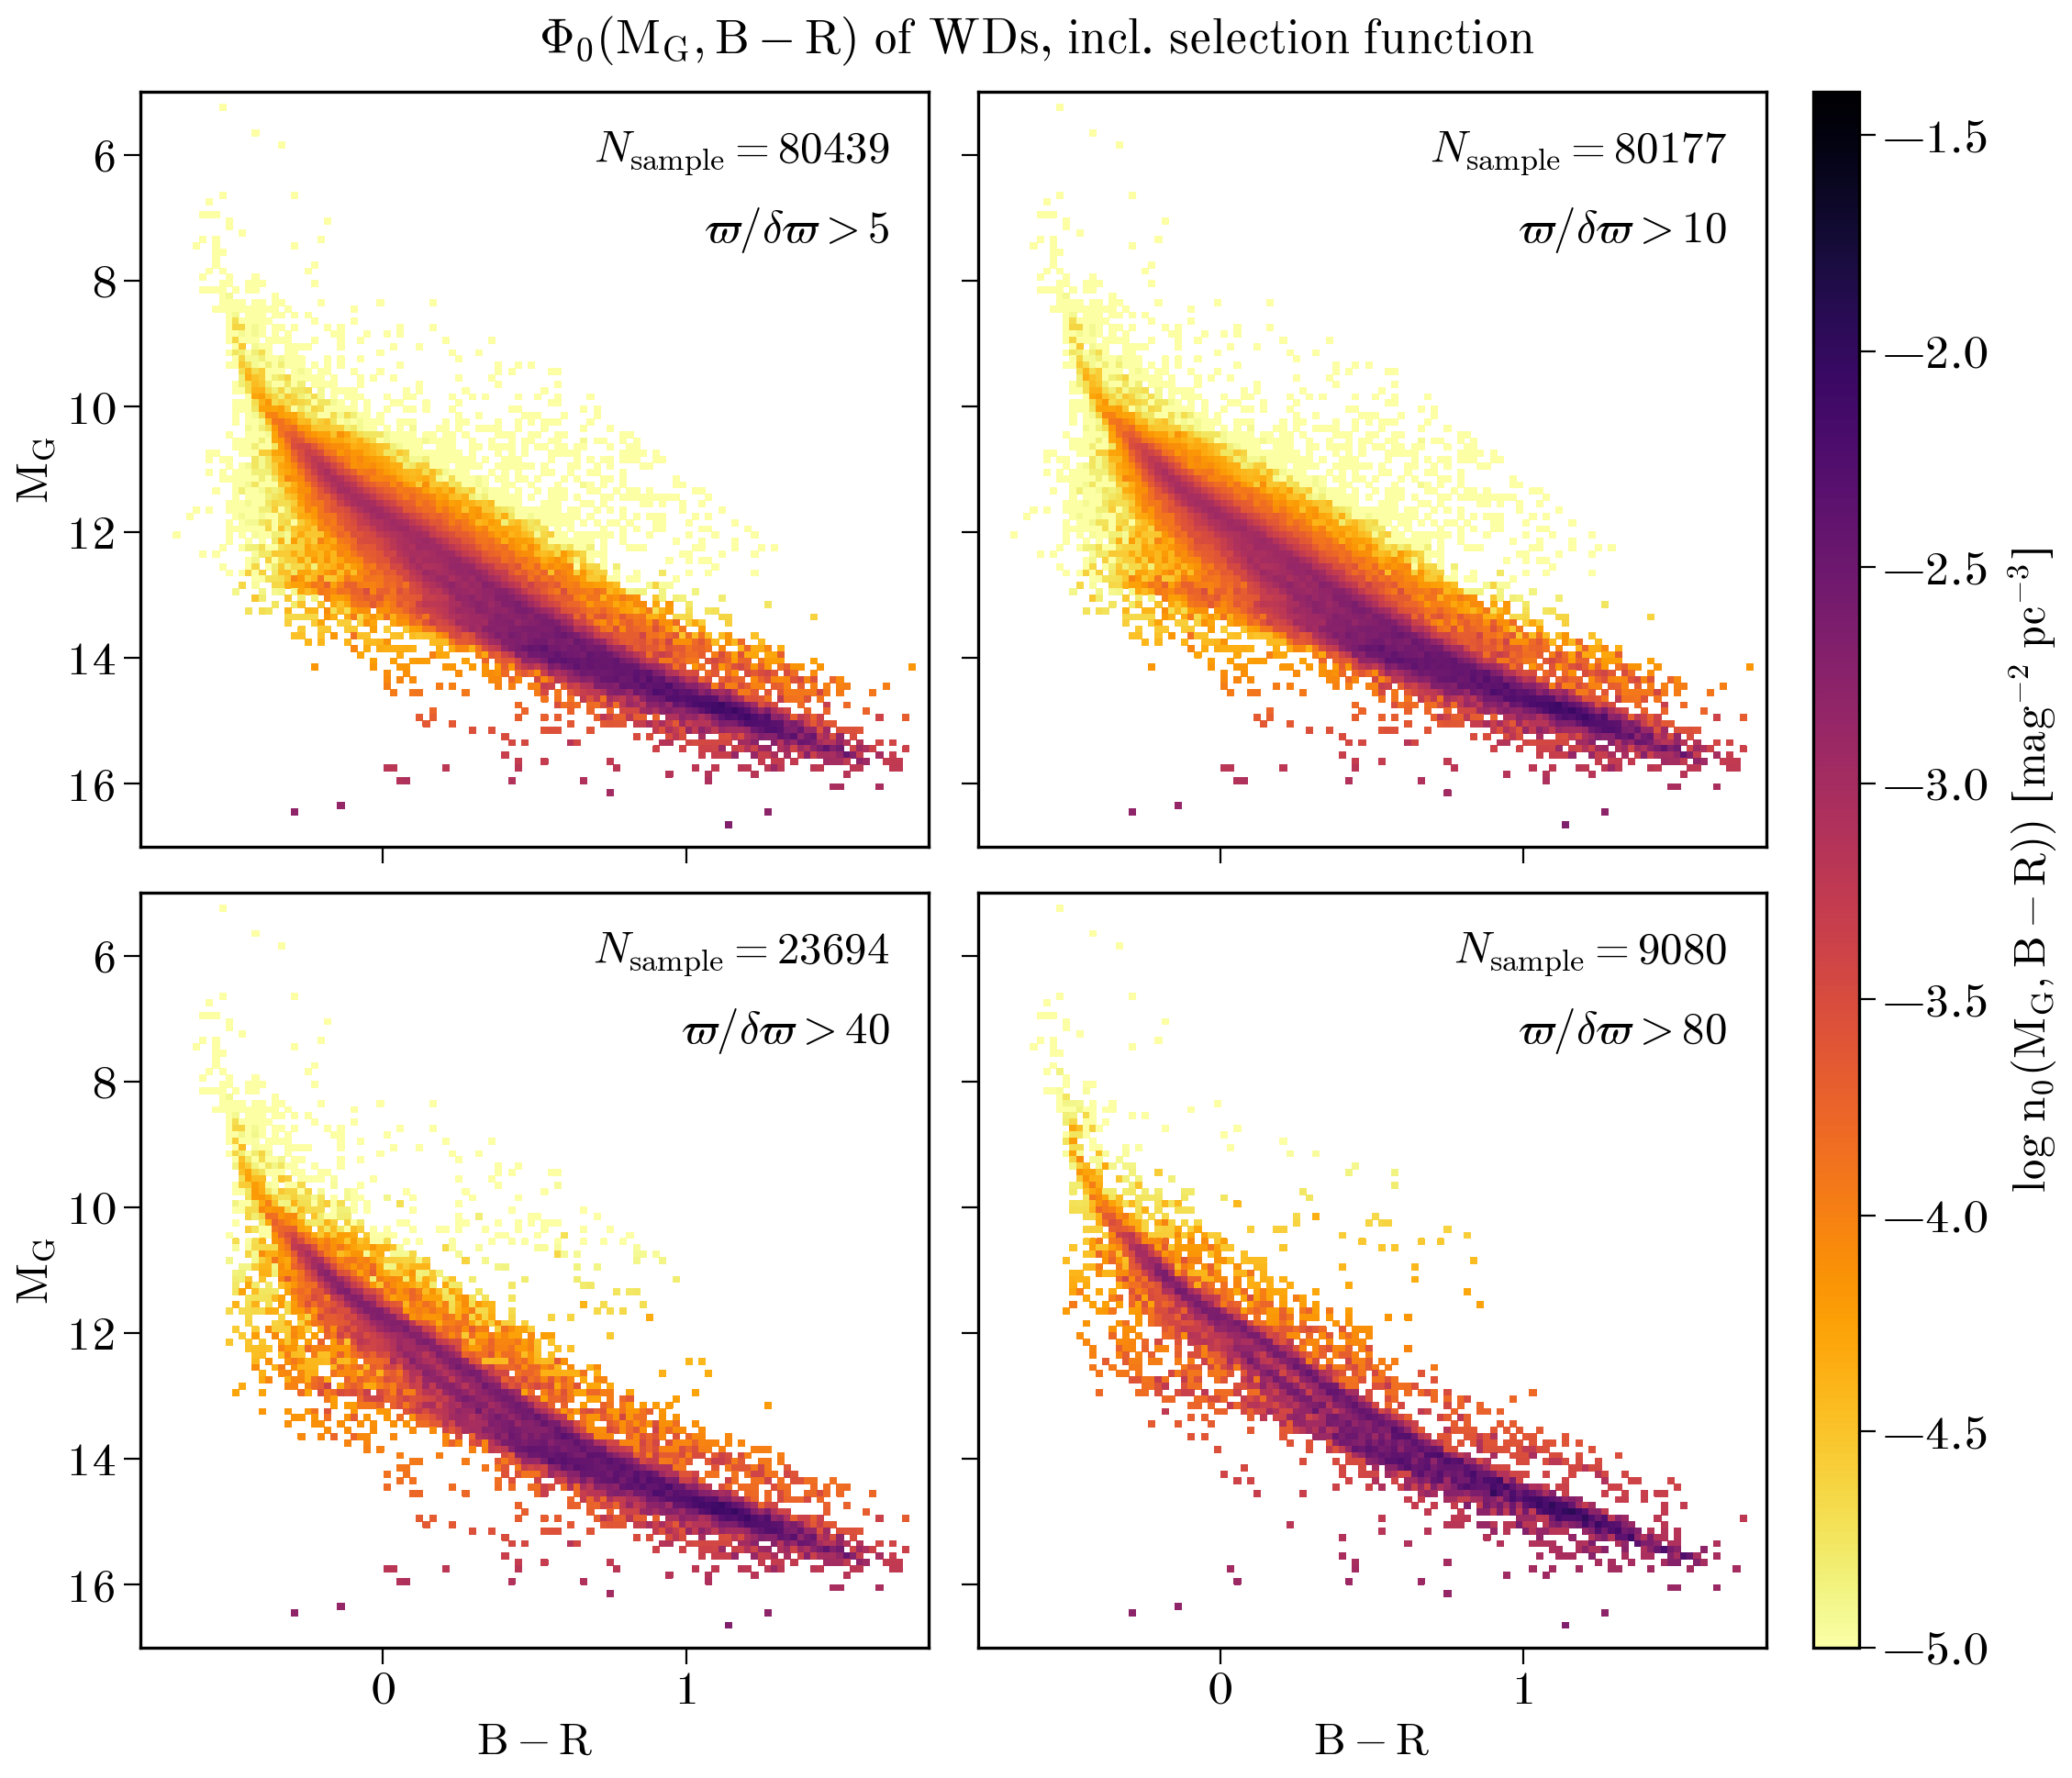

In [358]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, (plxSNmin, distribution) in zip(axes.flat, sub_distributions.items()):
    im = ax.pcolormesh(
            sub_xe, sub_ye, distribution.T - 9,  # kpc^-3 to pc^-3
            cmap=cmap_r,
            vmin=-5.0, vmax=-1.4)
    
    ax.text(0.95, 0.95, "$N_\mathrm{sample} = " + f"{sub_Ns[plxSNmin]}$", 
            transform=ax.transAxes, va='top',ha='right', fontsize='medium')
#     ax.text(0.95, 0.85, r"$\varpi_\mathrm{lim}=3$ mas", 
#             transform=ax.transAxes, va='top',ha='right', fontsize='medium')
    ax.text(0.95, 0.85, rf"$\varpi/\delta\varpi>{plxSNmin:.0f}$", 
            transform=ax.transAxes, va='top',ha='right', fontsize='medium')

cb = fig.colorbar(im, ax=axes, aspect=40)
cb.set_label(
    "log $\mathrm{n}_0(\mathrm{M}_\mathrm{G}, \mathrm{B}-\mathrm{R}))$ [mag$^{-2}$ pc$^{-3}$]",
    labelpad=8,
    rotation=90)
    
ax.set_xlim(sub_xe.min(), sub_xe.max())
ax.set_ylim(sub_ye.max(), sub_ye.min())
    
for ax in axes[:, 0]:
    ax.set_ylabel(r'$\mathrm{M}_\mathrm{G}$')
for ax in axes[-1]:
    ax.set_xlabel(r'$\mathrm{B}-\mathrm{R}$')
    
fig.suptitle(r'$\Phi_0(\mathrm{M}_\mathrm{G}, \mathrm{B}-\mathrm{R})$ of WDs, incl. selection function', 
             fontsize=24);

In [359]:
combined_distribution = None
for k, distribution in sub_distributions.items():
    if combined_distribution is None:
        combined_distribution = distribution
    else:
        combined_distribution[~distribution.mask] = distribution[~distribution.mask]

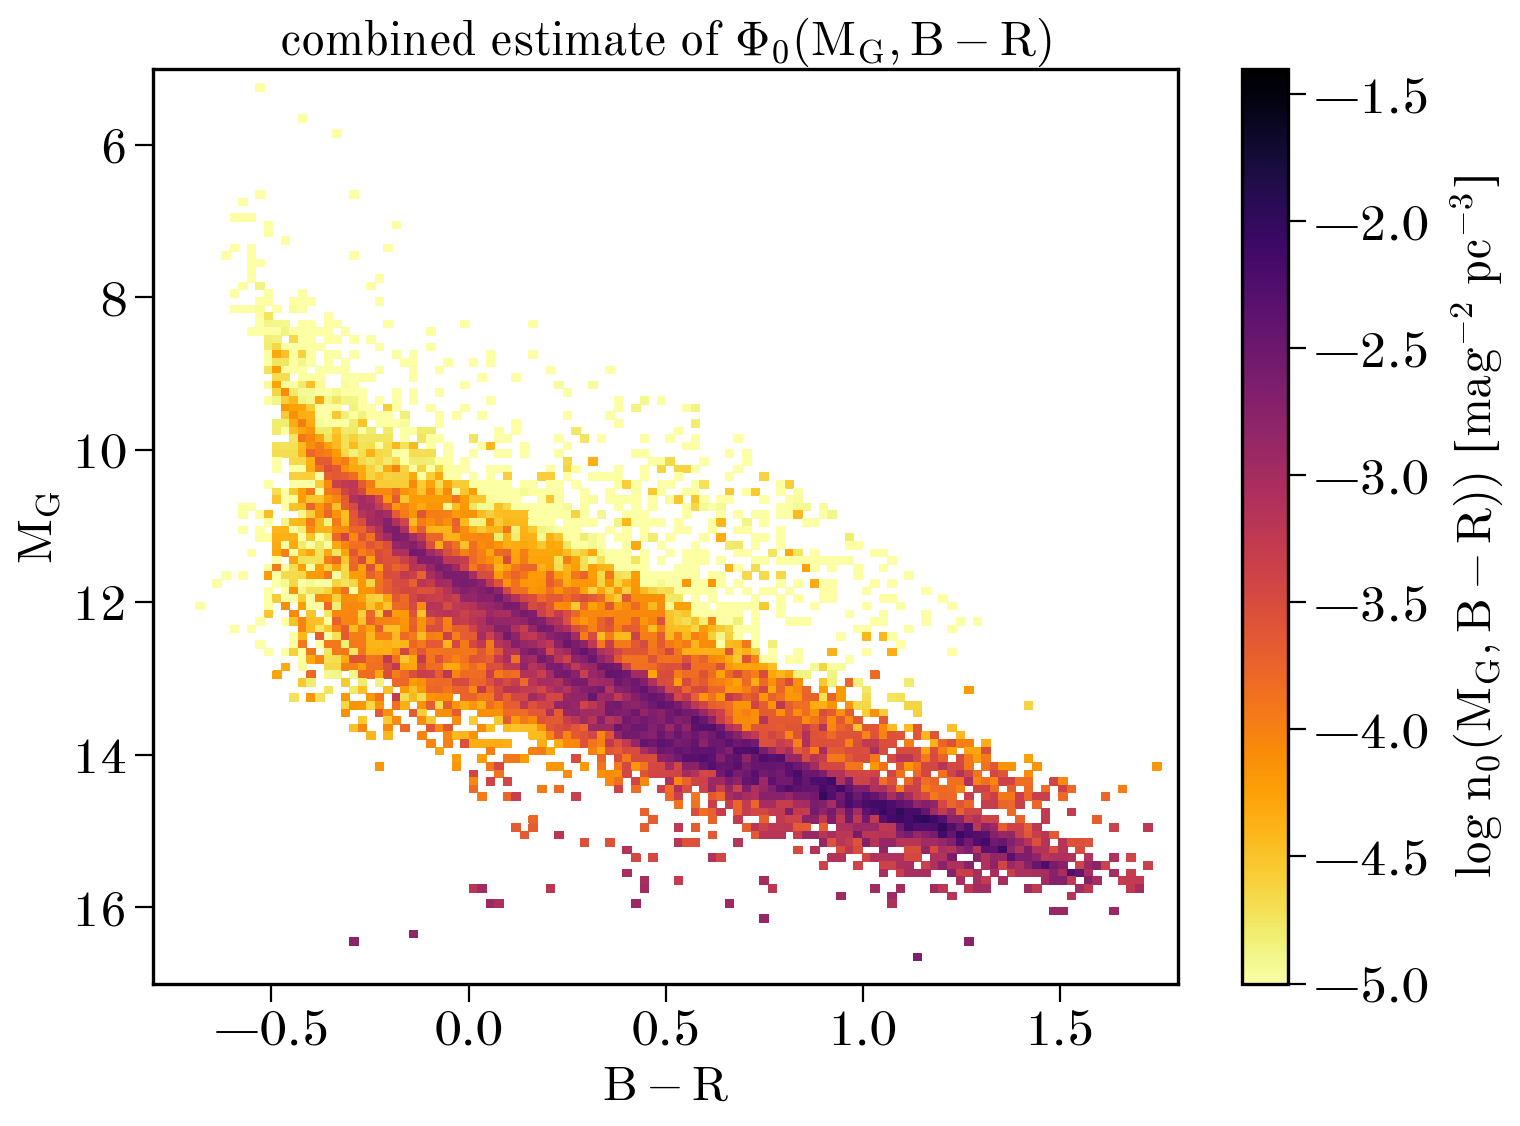

In [364]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5), 
                       tight_layout=True)

im = ax.pcolormesh(
        sub_xe, sub_ye, combined_distribution.T - 9,
        cmap=cmap_r,
        vmin=-5, vmax=-1.4)

ax.set_xlabel(r'$\mathrm{B}-\mathrm{R}$ [mag]')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{G}$ [mag]')

ax.set_xlim(xe.min(), xe.max())
ax.set_ylim(ye.max(), ye.min())

ax.set_xlabel(r'$\mathrm{B}-\mathrm{R}$')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{G}$')
ax.set_title(r'combined estimate of $\Phi_0(\mathrm{M}_\mathrm{G}, \mathrm{B}-\mathrm{R})$')
clb = fig.colorbar(im)
clb.set_label(
    "log $\mathrm{n}_0(\mathrm{M}_\mathrm{G}, \mathrm{B}-\mathrm{R}))$ [mag$^{-2}$ pc$^{-3}$]",
    labelpad=8,
    rotation=90)

filename = "WD300pc_combined_Phi0_estimnate"
# plt.savefig(filename+".png", dpi=300)
# plt.savefig(filename+".pdf")

### APW didn't touch below here...

attempt at combining the plot just made with the upper limits (presuming 1 pointe per MC-spaxel); the following is conceptually and practically not yet right. It is currently not art of the draft 

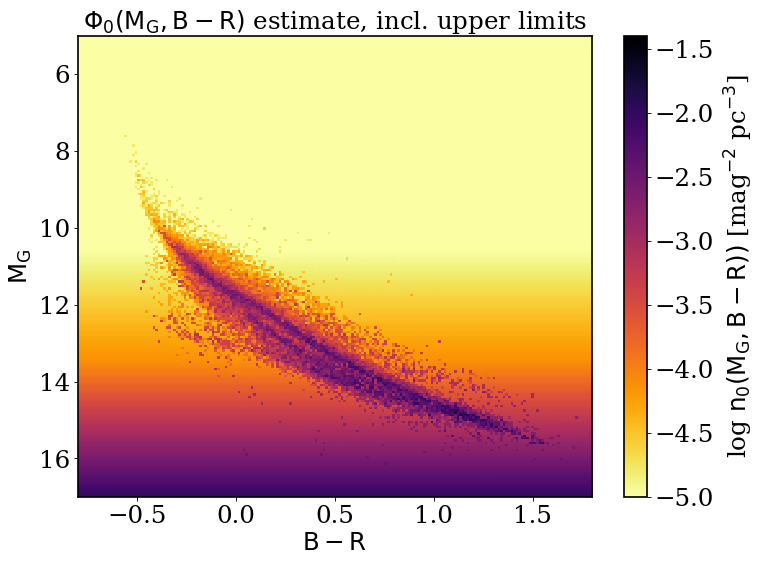

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,7.5), tight_layout=True)

im = ax.imshow(combined_upper_limits,
           extent=[BmRmin, BmRmax, MGmax, MGmin],
           aspect='auto',
           interpolation='none',
           cmap=cmap_r,
           vmin=-5.0,
           vmax=-1.4)

ax.set_xlabel(r'$\mathrm{B}-\mathrm{R}$')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{G}$')
ax.set_title(r'$\Phi_0(\mathrm{M}_\mathrm{G}, \mathrm{B}-\mathrm{R})$ estimate, incl. upper limits')
clb = fig.colorbar(im)
clb.set_label(
    "log $\mathrm{n}_0(\mathrm{M}_\mathrm{G}, \mathrm{B}-\mathrm{R}))$ [mag$^{-2}$ pc$^{-3}$]",
    labelpad=8,
    rotation=90)
plt.tight_layout()
filename = "WD-LCF-incl-upper-limits"
plt.savefig(filename+".png", dpi=300)
plt.savefig(filename+".pdf")

#plt.text(-0.7,6.5, "combined estimate of $\Phi_0(M,c)$",fontdict=font)
#plt.text(0.5,8., "$\omega_{lim}=3$ mas",fontdict=font)
#plt.text(0.5,9.5, "$\omega/\delta\omega>$ "+str(plxSNmin),fontdict=font)
#filename = "WD300pc_plxSN_{0:d}.png".format(np.int(plxSNmin))
#plt.savefig(filename)



Note that the next sets of plots, with the marginalized histograms, is "historica"; they are supplanted by other plots in the paper.

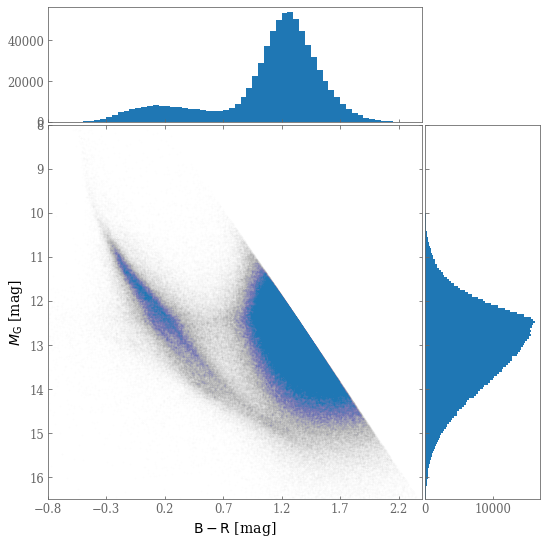

In [ ]:
# CMD plot of the initial sample
x = BmR  # rename to use stolen code
y = MG

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
plt.xticks(np.arange(-0.8, 2.4, 0.5))

# the scatter plot:
ax_scatter.scatter(x, y, s=2, alpha=0.002)
plt.xlabel(r'$\rm B - R$ [mag]')
plt.ylabel(r'$M_{\rm G}$ [mag]')

# now onto the marginalized distributions

ax_histx = plt.axes(rect_histx, sharex=ax_scatter)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy, sharey=ax_scatter)
ax_histy.tick_params(direction='in', labelleft=False)

# now determine nice limits by hand:
binwidth = 0.05
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-0.8, 2.4))
ax_scatter.set_ylim((16.5, 8.))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

file_name = 'initial_eDR3_query_CMD_distribution.png'
plt.savefig(file_name,
            format='png');  # the output did not come our right; to be checked

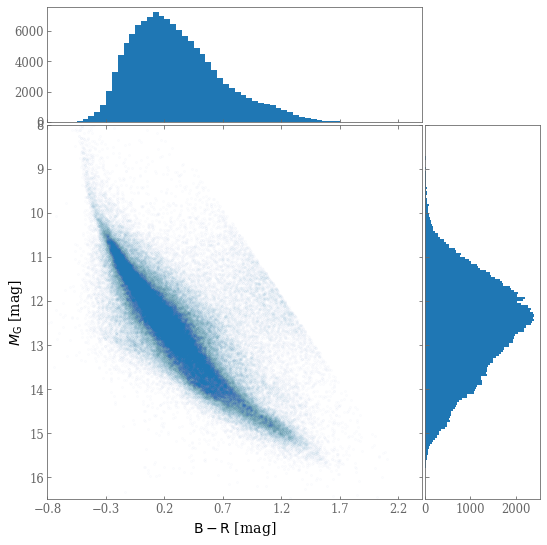

In [ ]:
# CMD plot
x = BmR_af
y = MG_af

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
plt.xticks(np.arange(-0.8, 2.4, 0.5))

# the scatter plot:
ax_scatter.scatter(x, y, s=5, alpha=0.01)
plt.xlabel(r'$\rm B-R$ [mag]')
plt.ylabel(r'$M_{\rm G}$ [mag]')

# now onto the marginalized distributions

ax_histx = plt.axes(rect_histx, sharex=ax_scatter)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy, sharey=ax_scatter)
ax_histy.tick_params(direction='in', labelleft=False)

# now determine nice limits by hand:
binwidth = 0.05
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-0.8, 2.4))
ax_scatter.set_ylim((16.5, 8.))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

#plt.tight_layout()

file_name = 'astrometrical_fidelity_cleaned_CAMD_distribution.png'
plt.savefig(file_name, format='png');
# the output did not come our right; to be checked

(16.0, 5.0)

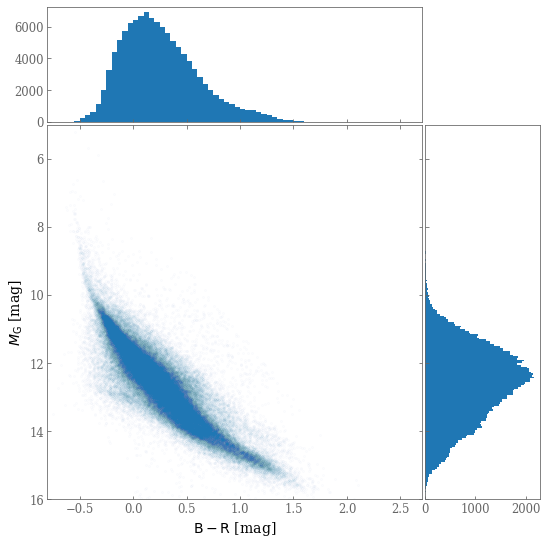

In [ ]:
# the random data
x = BmR_c
y = MG_c

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
plt.xlabel(r'$\rm B-R$ [mag]')
plt.ylabel(r'$M_{\rm G}$ [mag]')
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y, s=5, alpha=0.01)

# now determine nice limits by hand:
binwidth = 0.05
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-0.8, 2.7))
ax_scatter.set_ylim((16., 5.))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())